In [181]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import pyro
import torch
import pyro.optim as optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO, Predictive, MCMC, NUTS
from pyro.distributions import constraints

pyro.enable_validation(True)

# Type Level Model
Here, we will model each post as coming from one of four types.

# Data

First, we load the Reddit datasets

In [182]:
comments = dict()
with open('../data/results/Comments.json') as f:
    for line in f:
        post = json.loads(line)
        comments[post['pid']] = post['api_num_comments'], post['comments']

In [183]:
corrections = []
with open('../data/results/CorrectionPairs.json') as f:
    for line in f:
        corrections.append(json.loads(line))

In [184]:
news = []
with open('../data/results/NewsPairs.json') as f:
    for line in f:
        news.append(json.loads(line))

Gather relevant variables

In [185]:
def processData(data, items, comments, minutes=60, offset=0):
    for idx, n in enumerate(items):
        i = idx + offset
        
        isNews = 'isFakeStory' in n['r']['reviewRating']
        news_id = n['p']['id']
        
        num_cmts, cmts = comments[news_id]
        c_body_lens = []
        c_ups = []
        c_downs = []
        unique_authors = set()
        for c in cmts:
            # skip if comment not created in first _ mins
            if c['delta_seconds'] > minutes * 60:
                continue

            c_minutes = c['delta_seconds'] / 60
            if c_minutes <= minutes:   # cmts in first _ mins
                data[i, 7] += 1
            
            c_body_lens.append(c['body_len'])
            c_ups.append(c['ups'])
            c_downs.append(c['downs'])
            
            if c['author']:
                unique_authors.add(c['author'])

        data[i, 0] = num_cmts
        if isNews:
            data[i, 1] = 1 if n['r']['reviewRating']['isFakeStory'] else 0
        else:
            data[i, 1] = 3 if n['r']['reviewRating']['isFakeClaim'] else 2
        data[i, 2] = np.mean(c_body_lens) if c_body_lens else 0.
        data[i, 3] = np.std(c_body_lens) if c_body_lens else 0.
        data[i, 4] = np.mean(c_ups) if c_ups else 0.
        data[i, 5] = np.std(c_ups) if c_ups else 0.
        data[i, 6] = len(unique_authors) if unique_authors else 0.
    return data

In [186]:
num_p_indep = 8
data = np.zeros((len(news) + len(corrections), num_p_indep))

data = processData(data, news, comments)
data = processData(data, corrections, comments, offset=len(news))

Variables (in order):

0. num_comments
1. type
2. comment_length_avg
3. comment_length_std
4. comment_upvotes_avg
5. comment_upvotes_std
6. num_unique_comment_authors
7. num_comments in first _ mins

types

0. Real News
1. Fake News
2. Correction on Real News
3. Correction on Fake News

t level Variables (in order):

0. Is Review? (vs. news)
1. Is about fake story? (Not included yet)

In [187]:
# select relevant indep vars
p_data = data[:, (2,4,6,7)]  # avg cmt length, avg upvotes, num authors, num initial comments
p_data = data[:,7].reshape(-1,1)  # num comments in 1st hr
p_types = data[:,1] # type of each post.
t_data = np.array([[0, 0],
                   [0, 1],
                   [1, 0],
                   [1, 1]])

# add bias terms
p_bias = np.ones_like(p_data)
t_bias = np.ones((t_data.shape[0],1))
p_data = np.concatenate((p_bias, p_data), axis=1)
t_data = np.concatenate((t_bias, t_data), axis=1)

# get dep var
y = data[:,0].reshape(-1,1) + 1

split into train/test

In [188]:
train_frac = 0.7
num_obs = p_data.shape[0]
idx = np.random.binomial(1, train_frac, size=num_obs).astype(bool)

p_data_train = p_data[idx,:]
p_data_test = p_data[~idx,:]

p_types_train = p_types[idx]
p_types_test = p_types[~idx]

y_train = y[idx,:]
y_test = y[~idx,:]

-----

# Modeling

Cast data to torch tensors

In [189]:
p_data_train = torch.Tensor(p_data_train)
p_data_test = torch.Tensor(p_data_test)
p_types_train = torch.Tensor(p_types_train)
p_types_test = torch.Tensor(p_types_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)
t_data = torch.Tensor(t_data)

2 Regressions.

Post-Level Regression

y_pt = phi_0,t * bias + phi_1,t * first_hour_comments + epsilon_pt

Type-Level Regressions (2)

phi_0t = eta_00 * bias + eta_01 silliness_t + nu_0t

phi_1t = eta_10 * bias + eta_11 silliness_t + nu_1t

In [212]:
def model(p_data, p_types, t_data, y):
    num_posts, num_p_indeps = p_data.shape
    num_types, num_t_indeps = t_data.shape
    
    # define a prior for our regression variables
    alpha_loc = torch.zeros((num_p_indeps, num_t_indeps))
    alpha_scale = 1. * torch.ones((num_p_indeps, num_t_indeps))

    with pyro.plate("t_indep", num_t_indeps, dim=-1) as ti:
        with pyro.plate("p_indep1", num_p_indeps, dim=-2) as pi:
            eta = pyro.sample("eta", dist.Normal(alpha_loc, alpha_scale))

    
    
    with pyro.plate("type", num_types, dim=-1) as t:
        with pyro.plate("p_indep2", num_p_indeps, dim=-2) as pi:
            phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)

            phi_dist = dist.Normal(phi_loc, 0.1)
            phi = pyro.sample("phi", phi_dist)
    
    
#     pareto_alpha = pyro.sample("pareto_alpha", dist.HalfNormal(0.1))
        
    # for each post, use the correct set of coefficients to run our post-level regression
    with pyro.plate("post", num_posts, dim=-1) as p:
        
        t = p_types[p].long()

        # indep vars for this post
        indeps = p_data[p,:]
        
        coefs = phi[:,t] # (num_p_indeps,num_posts)

        # calculate the mean: desired shape (num_posts, 1)
        mu = torch.mul(coefs, indeps.T).sum(dim=0)  # ((num_p_indeps, num_posts) .* (num_p_indeps, num_posts)).sum(over indeps)
#         print(f"mu: {mu.shape}")
#         print(f"sigma (model): {sigma}")
        # sample
#         print(f"y: {y.shape}")
#         print(f"pareto_alpha: {pareto_alpha.shape}")
#         print(f"pareto_alpha: {pareto_alpha}")
        
        print(y[p,0])
        pyro.sample("obs", dist.Pareto(torch.ones((num_posts,)) - 1e-3, torch.exp(mu)), obs=y[p,0])


In [213]:
def model(p_data, p_types, t_data, y):
    num_posts, num_p_indeps = p_data.shape
    num_types, num_t_indeps = t_data.shape
    
    # define a prior for our regression variables
    alpha_loc = torch.zeros((num_p_indeps, num_t_indeps))
    alpha_scale = 1. * torch.ones((num_p_indeps, num_t_indeps))

    with pyro.plate("t_indep", num_t_indeps, dim=-1) as ti:
        with pyro.plate("p_indep1", num_p_indeps, dim=-2) as pi:
            eta = pyro.sample("eta", dist.Normal(alpha_loc, alpha_scale))

    
    
    with pyro.plate("type", num_types, dim=-1) as t:
        with pyro.plate("p_indep2", num_p_indeps, dim=-2) as pi:
            phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)

            phi_dist = dist.Normal(phi_loc, 0.1)
            phi = pyro.sample("phi", phi_dist)
    
    
#     pareto_alpha = pyro.sample("pareto_alpha", dist.HalfNormal(0.1))
    
    subsample_size = 100
        
    # for each post, use the correct set of coefficients to run our post-level regression
    with pyro.plate("post", num_posts, subsample_size=subsample_size, dim=-1) as p:
        
        t = p_types[p].long()

        # indep vars for this post
        indeps = p_data[p,:]
        
        coefs = phi[:,t] # (num_p_indeps,num_posts)

        # calculate the mean: desired shape (num_posts, 1)
        mu = torch.mul(coefs, indeps.T).sum(dim=0)  # ((num_p_indeps, num_posts) .* (num_p_indeps, num_posts)).sum(over indeps)
#         print(f"mu: {mu.shape}")
#         print(f"sigma (model): {sigma}")
        # sample
#         print(f"y: {y.shape}")
#         print(f"pareto_alpha: {pareto_alpha.shape}")
#         print(f"pareto_alpha: {pareto_alpha}")
        
        print(y[p,0])
        pyro.sample("obs", dist.Pareto(torch.ones((subsample_size,)) - 1e-3, torch.exp(mu)), obs=y[p,0])


In [214]:
def guide(p_data, p_types, t_data, y):
    num_posts, num_p_indeps = p_data.shape
    num_types, num_t_indeps = t_data.shape
    
    # define a prior for our regression variables
    
    alpha_loc = torch.zeros((num_p_indeps, num_t_indeps))
    alpha_scale = 1. * torch.ones((num_p_indeps, num_t_indeps))
    
    # The zeros and ones are the "alpha" in the graphical model from the proposal
    eta_loc = pyro.param("eta_loc", alpha_loc)
    eta_scale = pyro.param("eta_scale", alpha_scale, constraint=constraints.positive)
            
    with pyro.plate("t_indep", num_t_indeps, dim=-1) as ti:
        with pyro.plate("p_indep1", num_p_indeps, dim=-2) as pi:
            eta = pyro.sample("eta", dist.Normal(eta_loc, eta_scale))
    
    phi_scale = pyro.param("phi_scale", 
                           0.1 * torch.ones((num_p_indeps, 1)), 
                           constraint=constraints.positive) # share among all types.
    
    with pyro.plate("type", num_types, dim=-1) as t:
        with pyro.plate("p_indep2", num_p_indeps, dim=-2) as pi:
            phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)

            phi = pyro.sample("phi", dist.Normal(phi_loc, phi_scale[:]))
    
#     pareto_alpha_scale = pyro.param('pareto_alpha_scale', 0.1 * torch.Tensor([1.]),
#                              constraint=constraints.positive)
#     pareto_alpha = pyro.sample("pareto_alpha", dist.HalfNormal(pareto_alpha_scale))
#     print(f"sigma (guide): {sigma}")

In [215]:
pyro.clear_param_store()

## Traces (to double check tensor shapes)

In [216]:
import pyro.poutine as poutine

In [217]:
trace = poutine.trace(model).get_trace(p_data_train[:250], p_types_train[:250], t_data, y_train[:250])
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

tensor([  1.,  44.,   1.,   1.,   1.,  14.,   1.,   1.,   1.,  12.,   1.,   1.,
         89.,   1.,   1.,   1.,   5.,  11.,  23.,   1.,   1.,   1.,   1.,  15.,
          2.,  80.,   1.,   1.,   1.,   2.,   1.,   2.,   1.,   1.,  13.,  16.,
        133.,  12.,   1.,   1.,   8.,   1.,   1.,   1.,   1., 105.,   1.,   1.,
          1.,  10.,   1.,   1.,   1.,   1.,   8.,  53.,   1.,   1.,   1.,   4.,
          1.,   1.,   1.,  27.,   7.,  11.,   1.,  10.,   1.,   1.,   1.,   1.,
          1.,  42.,   1.,   2.,   1.,   1.,  38.,   6.,   1.,  17.,   1.,   1.,
         95.,   1.,   1.,  23.,  14.,   1.,   9.,   1.,   1.,  16.,   1.,   1.,
          2.,   1.,   1.,   1.])
Trace Shapes:        
 Param Sites:        
Sample Sites:        
 t_indep dist       |
        value     3 |
     log_prob       |
p_indep1 dist       |
        value     2 |
     log_prob       |
     eta dist 2   3 |
        value 2   3 |
     log_prob 2   3 |
    type dist       |
        value     4 |
     log_prob      

In [218]:
trace = poutine.trace(guide).get_trace(p_data_train[:250], p_types_train[:250], t_data, y_train[:250])
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

Trace Shapes:      
 Param Sites:      
      eta_loc   2 3
    eta_scale   2 3
    phi_scale   2 1
Sample Sites:      
 t_indep dist     |
        value   3 |
     log_prob     |
p_indep1 dist     |
        value   2 |
     log_prob     |
     eta dist 2 3 |
        value 2 3 |
     log_prob 2 3 |
    type dist     |
        value   4 |
     log_prob     |
p_indep2 dist     |
        value   2 |
     log_prob     |
     phi dist 2 4 |
        value 2 4 |
     log_prob 2 4 |


# Inference

## SVI

In [173]:
SUBSAMPLE = False

svi = SVI(model,
          guide,
          optim.Adam({"lr": 1e-3}),
          loss=JitTrace_ELBO())

pyro.clear_param_store()
num_iters = 10000
losses = np.zeros((num_iters,))
for i in range(num_iters):
    if SUBSAMPLE:
        elbo = svi.step(p_data_train[:250], p_types_train[:250], t_data, y_train[:250])
    else:
        elbo = svi.step(p_data_train, p_types_train, t_data, y_train)
    losses[i] = elbo
    if i % 100 == 0:
        print("Elbo loss: {}".format(elbo))

pareto_alpha: torch.Size([1])
pareto_alpha: tensor([0.0136], grad_fn=<AbsBackward>)
tensor([1.0000e+00, 1.0000e+00, 1.5000e+01, 2.0000e+00, 1.0000e+00, 3.0000e+00,
        1.0000e+00, 7.5300e+02, 9.0000e+00, 2.0000e+00, 1.0000e+00, 2.5000e+01,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.1000e+01, 4.0000e+00, 1.0000e+00, 1.2000e+01, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 5.7000e+01, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        5.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.2430e+03,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
        6.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 3.0000e+01,
        1.0000e+00, 1.9000e+01, 1.7000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        4.0000e+00, 1.0000e+00, 1.00

<ipython-input-168-fb19ecf502aa>:28: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  pareto_alpha_scale = pyro.param('pareto_alpha_scale', 0.1 * torch.Tensor([1.]),
/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/venv/lib/python3.8/site-packages/pyro/poutine/subsample_messenger.py:52: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  result = torch.randperm(self.size, device=self.device)[:subsample_size].clone()
<ipython-input-167-c0f2d399d331>:43: TracerWarning: Converting a tensor to a Pyth

Elbo loss: 18564.314453125
Elbo loss: 23329.30859375
Elbo loss: 26405.2421875
Elbo loss: 31206.37109375
Elbo loss: 26550.669921875
Elbo loss: 24622.439453125
Elbo loss: 21882.54296875
Elbo loss: 32451.421875
Elbo loss: 36315.79296875
Elbo loss: 26119.337890625
Elbo loss: 26216.388671875
Elbo loss: 27706.458984375
Elbo loss: 24775.748046875
Elbo loss: 27569.63671875
Elbo loss: 18923.18359375
Elbo loss: 20143.84375
Elbo loss: 35173.15234375
Elbo loss: 24248.462890625
Elbo loss: 26319.7734375
Elbo loss: 25245.083984375
Elbo loss: 24407.462890625
Elbo loss: 23820.48828125
Elbo loss: 25080.130859375
Elbo loss: 23017.46484375
Elbo loss: 29865.619140625
Elbo loss: 28862.10546875
Elbo loss: 25482.017578125
Elbo loss: 31108.34375
Elbo loss: 20288.384765625
Elbo loss: 28243.3671875
Elbo loss: 21736.751953125
Elbo loss: 26143.3671875
Elbo loss: 28818.341796875
Elbo loss: 31486.87109375
Elbo loss: 29903.90234375
Elbo loss: 29173.59375
Elbo loss: 29964.34375
Elbo loss: 27372.119140625
Elbo loss: 22

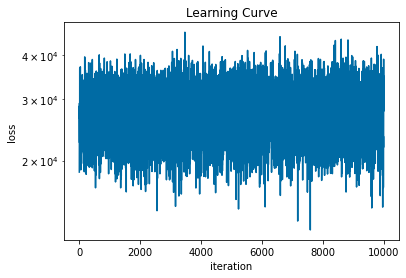

In [174]:
plt.plot(range(len(losses)), np.array(losses))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale("log")
plt.title("Learning Curve")
plt.show()

In [175]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape((1,num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(p_data_test, p_types_test, t_data, y_test).items()
               if k != "obs"}

pareto_alpha: torch.Size([])
pareto_alpha: 0.10988736152648926
tensor([  1.,   1.,   1.,   1.,   1.,  14.,   1.,  20.,   1.,   1.,   3.,   1.,
          1.,   3.,   1.,   1.,   1., 112.,   1.,   1.,  36.,   1.,   1.,   1.,
          1.,  14.,   2.,   1.,  13.,   1.,   1.,   1.,   3.,   1.,   2.,   8.,
          2.,   1.,   1.,   1.,   1.,   2., 388.,  20.,   2.,   1.,  11.,   1.,
          3.,   1.,   1.,   2.,   3.,   1.,   2.,   1.,   1.,   1.,   1.,   9.,
         73.,   1.,   1.,   1.,   5.,   2.,   1.,   1.,   2.,   3.,   1.,  81.,
         15.,   1.,   1.,   3.,   1.,   1.,   1.,   1.,   1.,   1.,  16.,   1.,
         10.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,   1.,   2.,
          8.,   1.,   4.,  11.])
pareto_alpha: torch.Size([])
pareto_alpha: 0.13129398226737976
tensor([ 2.,  1.,  3., 15.,  2.,  1.,  1.,  1.,  8.,  6.,  1.,  1.,  2.,  1.,
         1.,  1., 73.,  1.,  1.,  1.,  1., 27.,  4.,  1.,  1.,  3.,  1.,  1.,
         9.,  2.,  1.,  6.,  1., 10.,  1.,  5

tensor([ 1., 15.,  1.,  1.,  9.,  2., 29., 11.,  9.,  3.,  1.,  1.,  1., 23.,
         2.,  1.,  1.,  7.,  1.,  1., 12., 11., 22., 24.,  1.,  1.,  1.,  1.,
         1.,  1.,  2.,  1.,  2.,  8.,  1., 20.,  3.,  1.,  1.,  4.,  1.,  1.,
        48.,  9.,  4.,  1.,  1.,  1., 15.,  1.,  3., 88.,  4.,  5.,  1.,  1.,
         2.,  1., 17.,  1., 38.,  6., 23.,  2.,  1.,  1.,  1.,  1.,  2., 23.,
         3.,  3.,  1.,  1.,  9.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  4.,
         5.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  7.,  1.,  1.,  1.,  1.,
         1.,  1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0003]], grad_fn=<SelectBackward>)
tensor([  4.,   4.,   5.,   1.,  13.,   2.,   1.,   1.,   1., 137.,   1.,   1.,
          1.,   2.,   1.,   1., 124.,   1.,   5.,   1.,   1.,   1.,   6.,   1.,
          5.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   4.,   1.,   2.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,   2.,
          1.,   1.,   1

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0027]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   2.,   1.,  30.,  11., 167.,   3.,   1.,   1.,   1.,   1.,
          1.,   3.,   2.,   1.,   3.,   1.,   1.,   1.,   5.,   2.,   8.,   1.,
          1.,  16.,   1.,   1.,   1.,   1.,   1.,  14.,   1.,   1.,  14.,   1.,
          1.,   2.,   1.,   2.,   2.,   1.,   1.,   2.,  13.,   4.,   1.,   1.,
          3.,   1.,   1.,   3.,  48.,   1.,   1.,   1.,   4.,  48., 271.,   1.,
          6.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   2.,   1.,   1.,   1.,  13.,   1.,  26.,  23.,   9.,
          8.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   4.,   1.,   1.,   1.,
          3.,   1.,   1.,   2.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0018]], grad_fn=<SelectBackward>)
tensor([  1.,   1., 100.,   1.,  17.,   1.,   2.,   1.,  44.,   4.,   2.,  84.,
          1.,   1.,   1.,  23.,   9.,   1.,   2.,   1.,   4.,  

tensor([ 1.,  1.,  2.,  8.,  1.,  9.,  1., 26., 41.,  1.,  1.,  1.,  1., 20.,
         1.,  1.,  4.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  9.,
         1.,  1.,  1.,  3.,  8.,  1.,  1.,  3., 14.,  1.,  3.,  1.,  1.,  1.,
        10.,  1.,  1.,  9.,  7.,  1.,  1.,  1.,  1., 21.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  4.,  1.,  7.,  2.,  1., 32.,  9., 10., 26.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  3.,  7.,  1., 29.,  1.,
         1.,  1., 11.,  1.,  1.,  1.,  1., 49.,  1.,  1.,  1.,  2.,  4.,  7.,
         3.,  1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0022]], grad_fn=<SelectBackward>)
tensor([2.7000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00,
        1.0000e+00, 1.6000e+01, 6.6000e+01, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.6000e+01, 2.0000e+00,
        3.0000e+00, 3.0000e+00, 7.0000e+00, 4.0000e+00, 1.5000e+01, 2.0000e+00,
        2.0000e+00, 1.6

tensor([  9.,   1.,   1.,   1.,   1.,   1.,  24.,   2.,   7.,   1.,  28.,   2.,
          1.,   1.,   1.,   1.,  12.,   9.,   1.,  11.,   1.,   1.,   1.,   1.,
          4.,   4.,   5.,   9.,   4.,   1.,  11.,   1.,   1.,   1.,   5.,   2.,
          1.,   2.,   4.,   1.,   1.,   1.,   1.,   1.,   4.,   1.,   6.,   3.,
         24.,   2., 196.,   2.,   4.,   2.,   1.,   1.,   1.,   4.,   2., 388.,
          2.,   1.,   1.,   2.,   9.,   1.,   1.,  42.,   9.,   1.,   1.,   1.,
          1.,   3.,   1.,   2.,   2.,   3.,   1.,   1.,   1.,  27.,  14.,  10.,
          2.,   1.,   6.,  28.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,  28.,
          1.,   1.,   3.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0056]], grad_fn=<SelectBackward>)
tensor([ 35.,   1.,   1.,   3.,   1.,  17.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,  63.,   1., 278.,   1.,   1.,   1.,   1.,   1.,   3.,   1.,   6.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   4.,   1.,   1.,   9.,  

tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.6990e+03, 1.0000e+00,
        3.0000e+00, 5.5200e+02, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 4.0000e+00, 1.0000e+00, 7.0000e+00, 2.6000e+01, 3.0000e+00,
        3.5000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        7.0000e+00, 1.3000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00, 8.0000e+00,
        1.0000e+00, 1.0000e+00, 6.6000e+01, 8.0000e+00, 1.0000e+00, 1.4000e+01,
        4.7000e+01, 4.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 6.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00, 8.0000e+00,
        1.0000e+00, 1.0000e+00, 3.0000e+00, 1.8000e+01, 1.0000e+00, 1.0000e+00,
        4.0000e+01, 1.0000e+00, 1.0000e+

tensor([281.,  26.,   2.,   4.,   1.,   4.,  19.,   1.,   1.,   3.,   1.,  58.,
          1.,   1.,   1., 289.,   2.,   1.,   1.,   1.,  10.,  23.,   5.,   1.,
          1.,   2.,  10.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,
         38.,   6.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,
         61.,   1.,   1.,  16.,   1.,   2.,   1.,   1.,  15.,   2.,  11.,   1.,
          1.,   3.,   1.,   1.,   1.,   1.,   3.,  23., 196.,   1.,  12.,   4.,
          1.,   7.,   1.,   5.,   9.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,
          2.,   1.,   3.,   4.,   2.,   1.,   2.,   1.,   2.,   1.,   1.,   1.,
          1.,  27.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0036]], grad_fn=<SelectBackward>)
tensor([ 2.,  2., 50.,  1.,  1., 30.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,
         1.,  4., 12.,  1.,  5.,  1., 27.,  1.,  1.,  1., 58.,  1.,  4.,  1.,
         1.,  1.,  2.,  1.,  1.,  1., 38.,  1.,  3.,  2.,  1.,  1.,  1.,  1.,
 

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0009]], grad_fn=<SelectBackward>)
tensor([ 1.,  2.,  1.,  5.,  1.,  1.,  1., 29.,  2.,  1.,  2.,  1.,  1., 15.,
         1.,  8.,  1.,  1.,  1.,  1.,  1.,  1., 88.,  2.,  1., 43.,  1.,  1.,
        42.,  1.,  3.,  1.,  3., 58.,  1.,  3.,  7.,  5.,  1.,  2.,  1., 16.,
         1.,  1.,  6.,  1.,  3.,  2.,  1.,  1., 17.,  4.,  5., 70., 17.,  1.,
         2.,  1.,  1.,  1.,  4.,  1., 16.,  5.,  1.,  1.,  1.,  1.,  1.,  2.,
        10.,  3.,  1.,  1.,  1.,  8.,  1.,  1.,  2.,  1.,  1.,  2.,  2.,  1.,
         3.,  7.,  1.,  3., 10.,  1.,  1.,  1.,  3.,  1.,  4.,  2.,  1.,  1.,
         1.,  1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0028]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   6.,   1.,   8.,   2.,  26.,   1.,   1.,   1.,   3.,   3.,
          1.,   1.,   2.,  16.,   1.,   2.,  23.,   7.,   5.,   6.,  69.,   1.,
          2.,   1.,   1.,   1.,   2.,   1., 673.,  11.,   1.,   6.,   1.,   1.,
         23

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0046]], grad_fn=<SelectBackward>)
tensor([  2.,   1.,  20.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,  84.,   1.,
          1.,   1.,   7.,   3.,   1.,  26.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,  29.,   1.,   1.,   3.,  16.,   1.,   1.,   1.,   2.,   1.,   1.,
         59.,   1.,   1.,   1.,   1.,   1.,   1.,  42.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   3.,  11.,   1.,   1.,   1.,   1.,   4.,
         69.,   4.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,
          1.,   1.,  88.,  39.,  70.,   3.,   2.,  66.,   1.,  26.,   1.,  24.,
          1., 605.,   4.,   1.,   4.,   2.,   1.,   6.,   1.,   1.,  12.,   5.,
          1.,   1.,  23.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0030]], grad_fn=<SelectBackward>)
tensor([ 16.,   8.,   1.,   1.,   1.,   1.,  21.,   5.,   1.,  41.,   2.,  17.,
          1.,   6.,   1.,   9.,   1.,   1.,   2.,  12.,  11.,  

tensor([  1.,   1.,   2.,   5., 134.,   1.,  52.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   3.,  60.,   1.,  24.,  98.,   1.,   1.,   2.,   1.,   1.,
          8.,   6.,   1.,  11.,   1.,   2.,   3.,   1.,   1.,   1.,   1.,   1.,
          2.,   1.,  10.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,  61.,
          1.,   2.,   5.,   2.,   1.,   1.,   4.,   1.,   1.,   1.,   1.,   1.,
          3.,   1.,   9.,   1.,   1.,   3.,   1.,   3.,   1.,   2.,   1.,   1.,
          1.,  29.,   2.,   9.,   1.,   1.,  20.,   1.,   1.,   6.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   8.,  33.,   4.,   1.,  80.,   1.,   2.,
         15.,   1.,   6.,   7.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0074]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   1.,   1.,   2.,   1.,   2.,   1.,   3.,   1.,   2.,
          1.,   1.,  38., 123., 136.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   4.,   1.,   1.,   1.,   9.,  39.,  36.,   6.,  

tensor([  1.,   1.,   2.,  41.,   3.,   1.,   4.,   1.,   1.,   1.,   1.,  23.,
          1., 725.,   1.,   1.,  36.,   1.,   1.,   2.,   1.,   1.,   1.,  12.,
          2.,   1.,   1.,   1.,   1.,  12.,   1.,  11.,  51.,  51.,  23.,  53.,
          1.,  13.,   2.,  38.,   1.,  17.,   3.,   8.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,  41.,   1.,   2.,   1.,   1.,   1.,   1.,   1.,
          9.,   1.,   1.,  17.,   1.,   1.,   1.,   1.,   1.,   2.,  13.,  10.,
          1.,  18.,   1.,   6.,   7., 281.,  14.,   1.,   1.,   1.,  15.,  28.,
          8.,  15.,   1.,   1.,   1.,   1.,  11.,   1.,  14., 872.,   5.,   1.,
          4.,   1.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0008]], grad_fn=<SelectBackward>)
tensor([  1.,   1., 164.,   1.,   1.,   1.,  24.,   1.,   1.,  56.,  80.,   3.,
         14.,  44.,   1.,   1.,   1.,   6.,   1.,   1.,   1.,   1.,   1.,   2.,
        137.,   1.,   4.,   2.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,  

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0018]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,
          2.,   1.,   5.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   2.,  81.,   1.,  24.,   1.,   9.,   7.,   1.,   1.,   1.,   1.,
         25.,  93.,   1.,   1.,   1.,   1.,   1.,  27., 302.,   1.,   5.,  48.,
          1.,   1.,   1.,   7.,   2.,  87.,   1.,   3.,   1.,   4.,   2.,   8.,
          1.,   1.,   1.,   1.,   8.,   3.,   1.,   1.,   1.,   2.,   1.,   1.,
          1.,   1.,   2.,   1.,  12.,   9.,   1.,   1.,   7.,   7.,   1.,   4.,
         16., 289.,   1.,   1.,  12.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   3.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0032]], grad_fn=<SelectBackward>)
tensor([  1.,   3.,   2.,   3.,   1.,   1.,   1.,  22.,   1.,   2.,   3.,   3.,
          1.,   1.,   1.,   1.,   2.,  15.,   1.,   1.,   1.,  

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0024]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   2.,   6.,  13.,   1.,   1.,   3.,   2.,   1.,  23.,
          1.,   1.,   1., 253.,   1.,   1.,   1.,   2.,   2.,   1.,   1., 192.,
          1.,   1.,   1.,  11.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,  21.,
          5.,  40.,   1.,   2.,   7.,   1.,   1.,  21.,   5.,   1.,   1.,   1.,
          4.,   1.,   3.,   1.,   1.,  25.,   1.,   1.,  16.,  11.,  19.,   1.,
          1.,   7., 164.,   1.,   1.,  76.,   1.,   1.,   1.,   1.,   4.,   1.,
          2.,   1.,   2.,  20.,   6.,  12.,   1.,   2.,   1.,   1.,   1.,   7.,
          1.,   1.,   1.,   1.,   1., 161.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   2.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0045]], grad_fn=<SelectBackward>)
tensor([  2.,   1.,   1.,   1.,   7.,   1.,  19.,   1.,   1., 447.,  14.,   1.,
          7.,   1.,   1.,   1.,   1.,  20.,   1.,   1.,   5.,  

pareto_alpha: tensor([[0.0030]], grad_fn=<SelectBackward>)
tensor([2.0000e+00, 2.0000e+00, 4.0000e+00, 8.0000e+00, 4.4000e+01, 1.0000e+00,
        1.0000e+00, 5.0000e+00, 2.6000e+01, 2.0000e+00, 1.6000e+01, 9.0000e+00,
        1.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.9000e+01, 1.0000e+00, 1.0000e+00, 2.8900e+02, 1.0000e+00,
        1.0000e+00, 7.0000e+00, 1.6000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.4000e+01, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        5.0000e+00, 1.0000e+00, 1.0000e+00, 2.5000e+01, 7.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 4.3000e+01,
        4.6000e+01, 2.6000e+01, 6.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 2.9620e+03, 1.0000e+00, 2.0000e+00, 2.0000e+00,
        2.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00,
        4.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.000

tensor([ 31.,  61.,   1.,   1.,   1.,   1.,   1.,   1.,   8.,   5.,   7.,  30.,
          3.,   1.,  11.,   4.,   1.,   1.,   1.,  32.,   1.,   1.,   1.,   1.,
          1.,   1.,   8.,   1.,   1.,   1.,   3.,   3.,   1.,   1.,   2.,  14.,
          5.,   1.,   2.,   1.,   1.,  30.,   1.,   1.,   1.,   2.,   2.,   2.,
          2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1., 552.,   1.,   1.,  16.,   8.,   2.,   1.,
          1.,   4.,  48.,   2.,   2.,   1.,   1.,   7.,   1.,   1.,   1.,   1.,
        134.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,
          3.,   1.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0056]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   5.,   5.,   1.,   1.,   1.,   9.,   6.,   1.,   1.,
          1.,   1.,   1.,   1.,  13.,   1.,   4.,   7.,   1.,   4.,   1.,  28.,
          1.,   1.,   1.,   1.,   1.,   1.,   6.,   1.,   5.,  22.,   1.,  

tensor([  7.,   2.,   6.,   1.,   1.,   3.,   1., 161.,   1.,   1.,   1.,   1.,
          6.,   3.,   1.,  14.,  28.,   1.,  24.,   4.,   1.,   1.,   1.,  43.,
          1.,   1.,   1.,   1.,   1.,   1.,   2.,   4.,   1.,   1.,   1.,   1.,
          1.,   3.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,  54., 273.,
          1.,   1.,   1.,   1.,   1.,  30.,   1.,   1.,  12.,  35.,   1.,   6.,
         22.,   1.,   1.,   4.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,  20.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,  10.,
          1.,   1.,   2.,   1.,  10.,   1., 138.,   9.,   3.,   1.,   2.,   1.,
          1.,   3.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0033]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   9.,   1.,   2.,   1.,   2.,   2.,   1.,   6.,  12.,
          1.,   1.,  24.,   1.,  12.,   1.,   1.,   2.,   1.,   1.,   2.,   1.,
         16.,  89.,  26.,   1.,   1.,   3.,   2.,  78.,   1.,  33.,   1.,  

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0049]], grad_fn=<SelectBackward>)
tensor([ 15.,   1.,  17.,   8.,  21.,   1.,   1.,   1.,   7.,   1.,   4.,   1.,
          1.,   1.,   2.,   1.,   1.,   4.,   1.,   1.,  27.,   1.,   1.,   6.,
          1.,   2.,   1.,   1.,   1.,   2.,   1.,   1.,   2.,   1.,  13.,   1.,
          1.,   2.,   1.,   3.,   3.,   1.,   2.,   2.,   8.,   4.,   1.,   3.,
          1.,   5.,   6.,   1.,   7.,  10.,   1.,  10.,   2.,   1.,  48.,   2.,
          1.,   1.,   1.,   1.,   2., 380.,   1.,   2.,   1.,   2.,   1.,  42.,
          1.,   1.,   1., 112.,   1.,   1.,   1.,   1.,  46.,  30.,   1.,   1.,
          8.,   1.,   5.,  12.,   1.,   1.,   1.,   1., 134.,   4.,   1.,   1.,
          1.,  43.,   1.,   8.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0017]], grad_fn=<SelectBackward>)
tensor([ 6.,  1.,  2.,  6.,  1.,  1.,  1.,  1.,  7.,  8.,  1.,  1.,  2.,  2.,
         1.,  2.,  1.,  1.,  1.,  6., 29.,  1.,  4.,  1., 26.,  1

pareto_alpha: tensor([[0.0031]], grad_fn=<SelectBackward>)
tensor([  1.,   4.,   1.,   1.,   1.,  26.,   1.,  21.,  12.,  77.,   1., 239.,
         13.,   1.,   1.,   6.,   1.,   1.,  26.,  88.,   1.,   1.,  13.,   1.,
          1.,   2.,   1.,   9.,   1.,   1.,   1.,   1.,  32.,   1.,   1.,   1.,
          1.,   1.,   2.,   1.,   1.,   1.,   1.,  81.,  52.,   1.,   1.,  36.,
          2.,   1.,   1.,   1.,   2.,   1.,  10.,   3.,   2.,   2.,   1.,   1.,
          4.,  28.,   1.,   1.,  10.,   1.,   1.,   6.,   1.,   1.,   1.,  26.,
          1.,   1., 108.,  25.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,  79.,
          3.,   1.,   1.,   8.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   3.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0030]], grad_fn=<SelectBackward>)
tensor([  1.,  10.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          2.,   1.,  35.,   1.,   1.,   1.,   1.,   1.,   1., 300.,   1.,  82.,
          7.,  1

tensor([5.0000e+00, 1.0000e+00, 9.0000e+00, 4.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 8.0000e+00, 1.6000e+01,
        2.0000e+00, 1.0000e+00, 8.7000e+01, 1.3300e+02, 1.0000e+00, 1.1000e+01,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 2.2000e+01, 1.2000e+01, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 8.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 7.2000e+01,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        6.9000e+01, 2.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 3.0000e+01, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0200e+02, 1.0000e+00, 6.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.5000e+01,
        1.0000e+00, 2.0000e+00, 1.0000e+

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0015]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   1.,   9.,   1.,   3.,   4.,   1.,   1.,  76.,   1.,
          2.,   1.,   1.,   1.,   1.,  19.,   1.,   1.,   1.,   2., 131.,   1.,
          1.,  10.,   2.,   1.,   1.,  13.,   1.,   1.,   1.,   1.,   1.,  29.,
          1.,   2.,   1.,   3.,   6.,   5.,   3.,   1.,   1.,   1.,   1.,   8.,
          1.,   1.,   1.,  54.,  10.,   1.,  11.,  20.,   1.,   4.,   1.,   1.,
          6.,  14.,   2.,  73.,   6.,   2.,   1.,   5.,   1.,   2.,   1.,   1.,
         26.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   9.,   4.,   3.,   1.,
        289.,  10.,   9.,   1.,   1.,  91.,   1.,   1.,  26.,   3.,   2.,   1.,
          7.,   2.,   2.,   3.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0034]], grad_fn=<SelectBackward>)
tensor([2.9000e+01, 1.4000e+01, 1.0000e+00, 5.4200e+03, 1.0000e+00, 5.0000e+00,
        1.0000e+00, 2.1000e+01, 1.0000e+00, 3.8300e+02, 8.0000e

tensor([2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        6.0000e+00, 3.0000e+00, 7.3000e+01, 8.0000e+00, 8.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 8.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00,
        1.3000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 9.0000e+00, 1.0000e+01, 1.0000e+00, 4.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00,
        3.1900e+02, 1.0000e+01, 1.0000e+00, 2.0000e+00, 1.0000e+01, 5.7500e+02,
        4.0000e+00, 3.0000e+00, 1.0000e+

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0040]], grad_fn=<SelectBackward>)
tensor([15.,  1.,  8.,  1.,  1.,  3.,  2.,  1.,  1.,  4.,  1.,  2.,  1.,  1.,
         1.,  4.,  2.,  1.,  4.,  1.,  6.,  1.,  1.,  1.,  1.,  1.,  1., 42.,
        20.,  2.,  1.,  2., 20.,  8.,  1.,  4.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  2.,  1., 17.,  1.,  1.,  8.,  1.,  1., 44.,  2.,  1.,  1.,  1.,
         1., 18.,  1.,  1.,  1.,  1.,  2.,  4.,  1.,  2.,  1.,  1.,  1.,  7.,
         1.,  1.,  1., 10.,  1.,  1.,  1.,  2.,  3.,  1.,  1., 16.,  1.,  1.,
         4.,  1.,  2.,  1.,  4.,  1.,  1.,  2.,  6.,  3.,  1.,  1.,  1.,  1.,
         1., 25.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0011]], grad_fn=<SelectBackward>)
tensor([  2.,  15., 118.,   1.,   1.,   2.,   3.,   1., 113.,   1.,   1.,   1.,
          1.,  64.,   1.,   7.,  40.,   2.,   3.,   4.,   3.,   1.,   1.,  20.,
         41.,   2.,   1.,   1.,   1.,   3.,   1.,   1.,  28.,   1.,  69.,  43.,
          1

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0030]], grad_fn=<SelectBackward>)
tensor([1.0000e+00, 1.0000e+00, 2.6000e+01, 1.0000e+00, 3.0000e+00, 2.3900e+02,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 6.6000e+01, 6.0000e+00, 1.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 1.3000e+01, 1.0000e+00, 1.0000e+00,
        4.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        4.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.1000e+01, 7.4000e+01,
        1.0000e+00, 1.0000e+00, 3.0000e+00, 2.8000e+01, 1.0000e+00, 6.0000e+00,
        5.0000e+00, 1.0000e+00, 1.0000e+00, 8.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 5.1000e+01,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.2000e+01, 2.0000e+00, 2.0000e+00,
        1.0000e+00, 8.0000e+

tensor([  1.,   1.,  12.,   1.,   2.,   1.,   2.,   1.,   1.,   1.,   1.,   3.,
          1.,   3.,   8.,   1.,  25.,  30.,   1.,   3.,   1.,   2.,   4.,   4.,
         42.,   2.,   4.,   2.,   6.,   1.,   1.,   1.,   1.,   1.,   2.,   2.,
          1.,  13.,   1.,   1.,   1.,  23.,   3.,   1., 280.,   1.,   1.,  10.,
          1.,   1.,   1., 137.,   1.,   1.,  16.,   1.,   1.,   2.,   1.,   7.,
          1.,   1.,   2.,   6.,   2.,  73.,  25.,   5.,   8.,  22.,   7.,   2.,
          1.,   3.,  16.,   1.,   1.,   1.,   1.,   1.,   4.,   1.,  91.,   9.,
          1.,   1.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,  39.,   8.,   1.,
          1.,   1.,   1.,  56.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0016]], grad_fn=<SelectBackward>)
tensor([1.2000e+01, 1.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 2.6000e+01, 8.0000e+00, 1.0000e+00,
        2.0000e+00, 3.0000e+00, 1.2200e+02, 1.0000e+00, 2.0000e+00, 8.0000e

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0033]], grad_fn=<SelectBackward>)
tensor([2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.4000e+01, 1.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00, 1.5000e+01,
        1.0000e+00, 6.0000e+00, 3.0000e+00, 1.0000e+00, 2.9000e+01, 2.8000e+01,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        8.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.4000e+01,
        1.0000e+00, 5.8000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        6.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 9.0000e+00, 1.0000e+00,
        8.0000e+00, 1.0000e+00, 2.6000e+01, 3.7000e+01, 7.7000e+01, 1.0000e+00,
        4.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.2400e+02, 3.1000e+01, 1.0000e+00, 6.0000e+00,
        1.0000e+00, 1.0000e+

pareto_alpha: tensor([[0.0050]], grad_fn=<SelectBackward>)
tensor([ 31.,  42.,   6.,   3.,  10.,   1.,  13.,   7.,   1.,   2.,   1.,   1.,
          3.,   1.,   1.,   1.,  29.,   1.,   1., 265.,   6.,   1.,   1.,   1.,
          4.,   4.,   5.,   2.,   1.,   7.,   2.,   1.,   1.,   3., 152.,   1.,
          1.,   1.,   2.,   1.,   4.,   1.,   1.,   1.,   3.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   4.,   1.,   5.,   1.,   1.,   1.,
          4.,   1.,   1.,  37.,   1.,   6.,   1.,   2.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,  14.,   1.,   9.,   2.,   1.,   1.,   1.,   2.,
          1.,  68.,   1.,  18.,   1.,   6.,  44.,   1., 135.,   1., 112.,  11.,
         21.,   1.,   4.,   3.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0011]], grad_fn=<SelectBackward>)
tensor([  3.,   1.,   1.,   6.,   9.,   4.,   1.,   1.,   2.,   1.,   1.,   6.,
          2.,   1.,  29.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,
          5.,   

pareto_alpha: tensor([[0.0021]], grad_fn=<SelectBackward>)
tensor([  3.,  18.,   1.,   1.,   3.,   2.,   1.,   1.,   1.,   1.,   2.,   1.,
          1.,   1.,   1.,   1.,   1.,   2.,   9.,   3.,   2.,   6.,   7.,   1.,
          3., 289.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,   3.,   9.,   1.,
          1.,   2.,  11.,   1.,   1.,   1.,   1.,   1.,   1.,   7.,   6.,   1.,
          1.,   1.,   1.,   1.,  14.,  13.,   1.,   2.,   4.,   1.,  14.,   1.,
          5.,   1.,  69.,   2.,   1.,   3.,   9.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,  72.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   3.,   1.,   1.,   1.,  21.,   1.,   2., 125.,   2.,   7.,  70.,
          4.,   1.,   3.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[8.3535e-05]], grad_fn=<SelectBackward>)
tensor([  1.,  10.,   7.,   1.,   6.,   1.,   1.,   2.,   9.,   1.,   1.,  51.,
          9.,   2.,   1.,   1.,   2.,   5.,  19.,   1.,   4.,   1.,  87.,   1.,
          3.

pareto_alpha: tensor([[0.0007]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   1.,   2.,   1.,   3.,  35.,   1.,   1.,   1.,   1.,
          1.,   5.,   4.,   2.,  11.,   1.,   1.,  74.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1., 289.,   4.,   3., 118.,   1.,  16.,   2.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,   9.,   1.,
          6.,   2.,   1.,   4.,   7.,   2.,   1.,   1.,   1.,   3.,   6.,   1.,
          1.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   8.,
         46.,   4.,   2.,  31.,   1.,   1.,   4.,  12.,   1., 515.,   4.,   2.,
          5.,   1.,   1.,  12.,  26.,   1.,   1.,  23.,   1.,   2.,   1., 159.,
          1.,   1.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0060]], grad_fn=<SelectBackward>)
tensor([  1.,   2.,   1.,   8.,   1.,   1.,   1.,   1.,   6.,   1.,   2.,   1.,
          8.,   9.,  15.,   1.,   1.,   2.,   1.,   1.,  12.,   1.,   1.,   9.,
         39.,   

tensor([  1.,   1.,   3.,   1.,   1.,  54.,   1.,   1.,   1.,   3.,  67.,  10.,
          1.,   1.,   1.,   1.,   1.,  26.,   1.,   1., 552.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   6.,   2.,   4.,   1.,   1.,   1.,   3.,   1.,
          1.,   1.,   1.,   1.,   1.,  86.,   8.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,  67.,  26.,   1.,   1.,   4.,  15.,  18.,   1.,   2.,   2.,
          1.,   1.,   4.,  12.,   1.,   2.,   1.,   2., 241.,   1.,  14.,  25.,
          1.,   1.,   1.,   1.,   4.,   1.,   1.,  14.,   2.,   2.,   1., 164.,
         26.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   4.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0023]], grad_fn=<SelectBackward>)
tensor([  1.,   4.,   3.,   4.,   3.,   2.,   5.,   2.,   4.,   2.,   1.,   1.,
          1.,   1.,   1.,   5.,   1.,   4.,   4.,   3.,   4.,  10.,  10.,   1.,
          1.,   3.,   1.,   1.,   1.,   1.,   5.,   1.,   2.,   2.,   1.,  

pareto_alpha: tensor([[0.0020]], grad_fn=<SelectBackward>)
tensor([  6.,   1.,   1.,   4.,  24.,   1.,   2.,   1.,   2.,   2.,   1.,   1.,
          1.,   3.,  76.,   4.,   1.,   1.,   2.,   9.,   4.,  19.,   2., 122.,
          1.,   2.,   1.,   2.,   1.,   1.,  46.,   7.,   1.,   1.,   3.,   5.,
         40.,   1.,  44.,   8.,   1.,  52.,   5.,   1.,  15.,   1.,   1.,   1.,
         25.,   1.,  12.,   8.,   9.,   3.,   3.,   1.,   1.,   9.,  20.,   5.,
         73.,   1.,   1.,   1.,  42.,   1.,   1.,   1.,   1.,   4.,   1.,   1.,
         13.,   2.,  26.,   1.,  37.,   1.,   1.,   1.,   1.,   1.,   1.,   9.,
          1.,   1.,   1.,   1.,   1.,  20.,   1.,   1.,   1.,   1.,  31.,   9.,
          4.,   3.,   1.,   2.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0066]], grad_fn=<SelectBackward>)
tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.5000e+01, 9.4000e+01, 1.7000e+01, 2.8000e+01, 1.0000e+00, 1.0000e+00,
        1.0000e+

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0009]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   5.,   1.,   1.,   1.,   2.,   1.,   2.,   3.,   1.,   1.,
          1.,   3.,   9.,   4.,   1.,   1.,   4.,   1.,  18.,  57.,   1.,  26.,
          1.,  26.,   3.,   1.,  19.,   1.,   2.,   1.,   2.,   6.,  20.,   1.,
          7.,   1.,   1.,  18.,   1.,   4.,   1.,   1.,   1.,   1.,  20.,   1.,
         20.,   1.,   2.,  13.,   8.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,
          2.,   1.,   1.,   1.,   3.,   4.,   1.,  24.,   9.,   1.,   1., 605.,
          1.,   3.,   1.,   7.,   1.,   1.,   4.,   1.,   1., 904.,  15.,   2.,
          1.,   1.,   6.,   1.,   1.,   2.,   2.,   2.,   2.,   1.,   1.,   1.,
          1.,   2.,  10.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0018]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   3.,  14.,   1.,   1., 725.,   1.,   1.,   1.,   1.,   7.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,  33.,   7., 2

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0030]], grad_fn=<SelectBackward>)
tensor([ 29.,   1.,   1.,   1.,   6.,  12.,  17.,   1.,   1.,   1.,  20.,   1.,
          1.,   1.,  48.,   4.,   1.,   1.,   1.,   1.,   1.,   1.,  11.,   1.,
          1.,   1.,   1.,  26.,   1.,   1.,   1.,  16.,   1.,  56.,  44.,   1.,
          1.,   1.,   4.,   1.,   1.,   4.,   1.,   1.,   1.,   2.,   4.,   1.,
          1.,   1.,   5.,   1.,  48.,   3.,   1.,   1.,  15.,   1.,   1., 137.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   2.,  48.,  30.,   6.,   1.,   1.,   1.,   1.,   1.,   1.,  33.,
         10.,   2.,   3.,   1.,   1.,   1.,   1.,   1.,  58.,   2.,   1.,  32.,
          1.,   6.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0042]], grad_fn=<SelectBackward>)
tensor([  2.,   2.,   1.,   2.,   1., 904.,  10.,  12.,   1.,   2.,   1.,   1.,
          3.,  30., 135.,   6.,   1.,   3.,   1.,   1.,   5.,  

tensor([  1.,  13.,   1.,   1.,   3.,   1.,   3.,   1.,   1.,   2.,   1.,   9.,
          1.,  63.,   1.,   2.,   1.,   1.,   1.,   5.,  12.,   1.,   1.,   1.,
         30.,   1.,  25.,   1.,   2.,   1.,   1., 148.,   1.,   5.,   1.,   4.,
          1.,   1.,   4.,   1.,   1.,   1.,  23.,   2.,   1.,   4.,   2.,   3.,
          1.,   2.,  99.,   3.,   6.,   1.,   1.,   3.,   1.,   1., 159.,   4.,
          2.,   1.,  12.,   2.,   2.,   1.,   1.,   2.,   1.,   1.,   1.,   8.,
          2.,   1.,   1.,   1., 575.,  32.,   1.,   2.,   3.,   1.,   1.,   1.,
          1.,   7.,   3.,   2.,   1.,   4.,   1., 254.,   1.,   2.,   8.,   1.,
          1.,  29.,  51.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0069]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,  48.,   1.,   1.,   6.,   1.,   1.,   1.,   1.,   1.,
          2.,   1.,   1.,  10.,   9.,   1.,  13.,   1.,   1.,   1.,   6.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,  42.,   1.,   2.,   1.,  

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0034]], grad_fn=<SelectBackward>)
tensor([ 51.,   1.,  89.,   1.,   1.,   1.,   1.,   1.,   3.,   3.,   7.,   1.,
          2.,   1.,   4.,  29.,   3.,   2.,   1.,   2., 885.,  69.,   2.,   2.,
          1.,   1.,   1.,  49.,   1.,   3.,   1.,   1.,   1.,   1.,   1.,   1.,
         12.,   8.,   2.,   1.,   1.,   3.,   1., 743.,   3.,   1.,   1.,   3.,
          1.,   3.,   1.,   1.,   1.,   1.,   3.,   3.,   2.,   1.,   1.,   1.,
         64.,  20.,   2.,   1.,   9.,   2.,   1.,   7.,   1.,   1.,   1.,   8.,
          4.,   1., 447.,   1.,   1.,   1.,   1.,  18.,   3.,   1.,   1.,   1.,
          2.,   6.,   2.,   1.,   1.,  82.,   1.,   1.,   1.,   1.,   1.,   6.,
          1.,   1.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0028]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   4.,   1.,   1.,   3.,   1.,   1.,   6.,   2.,   4.,
          1.,   1.,  21.,   2.,   1.,   4.,   1.,   2.,  21.,  

pareto_alpha: tensor([[0.0004]], grad_fn=<SelectBackward>)
tensor([2.0000e+00, 1.0000e+00, 6.0000e+00, 1.4000e+01, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+01, 3.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00,
        2.2000e+01, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        6.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 6.0000e+00, 1.2000e+01, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 7.0000e+00, 1.0000e+00,
        2.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00,
        1.0000e+00, 1.4000e+01, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 7.0000e+00, 2.0000e+00, 2.9000e+01, 4.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+01, 1.0000e+00,
        1.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00, 1.000

pareto_alpha: tensor([[0.0033]], grad_fn=<SelectBackward>)
tensor([  3.,   1.,   8.,   1.,   1.,   1.,  30.,   2.,   2.,   6.,   1.,   1.,
          1.,   1.,   1.,  15.,   2.,   2.,   1.,   1.,   1.,   2.,   1., 240.,
          1.,   1.,   1.,   1.,   1.,   2.,  15.,   1.,   1.,   1.,   1.,   3.,
          7.,   6.,   1.,   1.,   1.,   1.,  42.,  18.,  12.,   2.,   2.,   1.,
          1.,   1.,   1.,   1.,   1.,  17.,  39.,   1.,   1.,   1.,   1.,   1.,
          2.,   1.,   1.,  28.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,  54.,
          1.,  17.,   1.,   3.,   9.,   2.,   5.,   9.,   1.,  13.,   1.,   1.,
          1.,   1.,   4.,  70.,   1.,  14.,   1.,   1.,   3.,   1.,   1.,   1.,
          3.,   1.,  80.,  17.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0039]], grad_fn=<SelectBackward>)
tensor([1.4610e+03, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        3.0000e+00, 3.9000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.2000e+01,
        1.0000e+

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0058]], grad_fn=<SelectBackward>)
tensor([  1.,   9.,   3.,  12.,   7.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,
          1.,   1.,   7.,   9.,   2.,   3.,   1.,   5.,   1.,   3.,   1.,   1.,
          1.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,  42.,  40.,   1.,   2.,
          3.,   1.,   1.,   1.,   5.,   1.,   6.,   8.,  11.,  51.,   1.,   1.,
         76.,   1., 105.,   1.,   3.,  11.,   1.,   1.,   1.,   1.,   2.,   2.,
         22.,   1.,  41.,   1.,   1.,   6.,   1.,   2.,  37.,   1.,   1.,   4.,
          3.,   1.,   1.,  16.,   2.,   1.,   1.,  70.,   1.,   1.,  21.,   9.,
          1.,   3.,   1.,   3.,  54.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   3.,  70.,  26.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0054]], grad_fn=<SelectBackward>)
tensor([  1.,   4.,   1.,   1.,   6.,   4.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   4.,   7.,   1.,   3.,  10.,   1.,  51.,  

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0017]], grad_fn=<SelectBackward>)
tensor([3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00, 2.0000e+00,
        2.9000e+01, 1.0000e+00, 2.3000e+01, 4.4000e+01, 1.0000e+00, 1.4610e+03,
        1.0000e+00, 8.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        1.5000e+01, 2.3000e+01, 1.0000e+00, 3.0000e+00, 1.0000e+00, 8.0000e+00,
        3.0000e+00, 1.0000e+00, 3.1900e+02, 2.0000e+00, 1.0000e+00, 1.1000e+01,
        1.0000e+00, 2.0000e+00, 1.3000e+01, 9.0000e+00, 1.0000e+01, 4.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        4.0000e+00, 7.0000e+00, 1.0000e+00, 1.0000e+00, 1.2000e+01, 2.0000e+01,
        1.0000e+00, 7.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.2430e+03, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        2.5000e+01, 2.0000e+

tensor([  1.,  59.,   7.,  14.,   1.,   1.,   3.,   8.,   1.,   2.,   1.,   2.,
         77.,   1.,   7.,   1.,   2.,   1.,   1.,   1.,   1.,   1.,  93.,  38.,
         15.,   1.,  15.,  16.,   8.,   1.,  13.,   5.,   1.,   1.,   3.,   1.,
         52.,   1.,   1.,   1.,   1.,   1.,   2.,   3.,   1.,  10.,   1.,   3.,
          1.,   1.,   1.,   1.,   1.,   3.,   1.,   1.,   1.,   1.,   1.,   1.,
         16.,   1.,   2.,   1.,   3.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   2.,   5.,   2.,   2., 112.,   2.,   1.,   7.,  14.,   1.,
          1.,   2.,   1.,   1.,   1.,   1.,  10.,   1., 188.,   1.,  66.,  17.,
          2.,   1.,   4.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0060]], grad_fn=<SelectBackward>)
tensor([2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00,
        5.5000e+01, 1.0000e+00, 1.2000e+01, 1.3000e+01, 1.0000e+00, 1.0000e

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0009]], grad_fn=<SelectBackward>)
tensor([  1.,   3.,   1.,   2.,   2.,   1.,   1.,   1.,   7.,   1.,   1.,   1.,
          1.,  23.,   1.,   1.,   1.,  13.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   4.,   1.,  20.,   1.,   1., 300.,   1., 191.,
          8.,   1.,   2.,   2.,   8.,   1.,   2.,   1.,   6.,   1.,   1.,   9.,
         26.,   1.,   2.,   1.,   5.,   1.,   1.,  27.,   1.,   1.,   1.,   1.,
          8.,   1.,  15.,   1.,  24.,   1.,   4.,   1.,   2.,   1.,   1.,  14.,
          1.,   8.,  12.,   1.,   1.,   1.,   1.,   2.,   4.,   1.,   1.,  28.,
          1.,   1.,  14.,   1.,   1.,   1.,   9.,   1.,   1.,   2.,   1.,   2.,
          7.,   1.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0006]], grad_fn=<SelectBackward>)
tensor([ 12.,   1.,   1.,   9., 131.,   1.,   1.,   2.,  31.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,  66.,   4.,  

tensor([  2.,  14.,   1.,   2.,   9.,   3.,   1.,   2.,   1.,  11.,   1.,  32.,
         37., 252.,   1.,   2.,   1.,   1.,   1.,   1.,   1.,   4.,   1.,   7.,
          1.,   1.,   1.,   1.,   4.,   1.,   1.,   1.,   2.,   1.,   1.,  42.,
          1.,  14.,   2.,   1.,   1.,  10.,   2.,   1.,   1.,   1.,   1.,   1.,
          1.,   8.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   3.,   1.,   1.,   1.,   3.,   1.,   4.,   3.,  53.,   9.,
         24.,   1.,  38.,   1.,   1.,   9.,   1.,   1.,   3.,   1.,   1.,   2.,
          1.,   1.,   1.,   2.,   2.,   1.,   1.,   1.,   1.,   9., 235.,   1.,
          2.,   1.,  69.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0023]], grad_fn=<SelectBackward>)
tensor([8.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 7.0000e+00, 5.4000e+01, 1.0000e+00, 4.0000e+00,
        9.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[8.3920e-05]], grad_fn=<SelectBackward>)
tensor([  1.,   2.,   3.,   2.,  35.,  11.,   1.,   1.,   1.,   4., 575.,   1.,
          1.,   2.,   2., 108.,   3.,   4.,   1.,  10.,   2.,   3.,   2.,  15.,
         43.,   1.,   3.,   1.,   1.,   1.,   1.,  76.,   1.,   2.,   9.,   1.,
          1.,  81.,   1.,   1.,   3.,   1.,   2.,   2.,   1.,   3.,   5.,   1.,
          2.,   4.,   5.,  16.,   1.,  87.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   6.,   3.,   4.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,
          1.,   1.,   1.,  24.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,  36.,
          1.,   2.,   3.,   1.,   1.,   4.,   1.,   1.,   1.,   1.,  13.,   1.,
          3.,   2.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0044]], grad_fn=<SelectBackward>)
tensor([1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 8.0000e+00, 1.6000e+01, 1.7800e+02, 1.0

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0017]], grad_fn=<SelectBackward>)
tensor([1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 2.7000e+01, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 4.2000e+01, 1.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0800e+02, 2.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0530e+03,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 6.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        8.0000e+00, 1.0000e+00, 1.0000e+00, 1.4000e+01, 2.0000e+00, 1.0000e+00,
        2.0000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.4000e+01, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00,
        1.1000e+01, 1.1000e+

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0033]], grad_fn=<SelectBackward>)
tensor([ 20.,   1.,   1.,   1.,   1.,   1.,   6.,   1.,   1.,   1.,   1.,   2.,
          1.,   1.,   1.,   1.,   1.,   3.,   1.,   1.,   1.,   1.,   3.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,  12.,   1.,   2.,   4.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,  44.,   1.,   1.,   1.,   1.,
         15.,   1.,   5.,   1.,   1.,   1.,   1.,   3., 289.,   9.,   6.,   1.,
          5.,   5.,   1.,   1.,   1.,   2.,   2.,  30.,   6.,   2.,  24.,   2.,
         44.,   1.,  53.,   1.,  25.,   1.,  40.,   2.,   1.,   1.,   1.,   6.,
          5.,   1.,   1.,   7.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,  15.,
          5.,   6.,   1.,   2.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0017]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   2.,   1.,   1.,  25.,   2.,   2.,   2.,  24.,   1.,   3.,
          1.,   1.,   1.,   8.,  42.,   1.,   1.,   2.,   2.,  

tensor([  1.,   1.,   2.,   1.,   2.,   1.,   1.,   1., 937.,   1.,   1.,   1.,
         23.,   6.,   1.,   1.,   3.,   2.,   3.,   2.,  28.,  16.,  11.,   2.,
          1.,   1.,   1.,   1.,   1.,   2.,   1.,   2.,   1.,   1.,   1.,  19.,
          1.,  16.,   1.,   1.,  11.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          6.,  32.,   4.,   5.,   1.,   1.,   1.,   1.,   1.,   1.,   6.,  43.,
          1., 159.,   6.,  39.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   3.,   1.,   6.,   1.,   7.,   1.,   3.,  12.,   1.,   1.,   1.,
          2.,  28.,   1.,   3.,   1.,   2.,   7.,  12.,   1.,   1.,   1.,   1.,
          1.,  23.,   3.,  57.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0021]], grad_fn=<SelectBackward>)
tensor([123.,   1.,   4.,   3.,   4.,   1.,   1.,  31.,   4.,   1.,   3.,   1.,
         73.,  26.,   4.,   1.,   3.,   9.,   6.,   8.,   1.,  15.,  33.,   1.,
          2.,   1.,   2.,   3.,   1.,   3.,   1.,  28.,   3.,  23.,   1.,  

tensor([1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        5.7500e+02, 3.0000e+00, 1.0000e+00, 1.0000e+01, 1.0000e+00, 8.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+01, 1.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 1.2000e+01, 1.0000e+00, 6.0000e+00, 1.5900e+02,
        1.3000e+01, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 6.6000e+01, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.6000e+01, 1.1100e+02, 1.0000e+00, 4.0000e+00,
        4.0000e+00, 2.0000e+01, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        5.0000e+00, 7.3000e+01, 1.0000e+00, 1.0000e+00, 3.0000e+00, 4.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 8.0000e+00, 1.0000e+00, 1.9870e+03,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+

tensor([ 1.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  8.,  6.,  1., 17.,  5.,
        11.,  4.,  1.,  1.,  2.,  1.,  1., 59.,  6.,  1.,  9.,  2.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 33.,  1.,
         1.,  1.,  3.,  1.,  1.,  1.,  6.,  1.,  4.,  1.,  1.,  1., 29.,  1.,
         1.,  1.,  1.,  2.,  1., 42.,  1.,  1.,  1., 15.,  1.,  1.,  1.,  1.,
        12.,  1.,  1.,  1.,  5.,  5.,  6.,  1.,  1.,  1.,  1.,  4.,  2.,  8.,
         1.,  1.,  2.,  1.,  2.,  2.,  1.,  4.,  3., 14.,  1.,  1.,  1.,  9.,
         1.,  1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0014]], grad_fn=<SelectBackward>)
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  1.,  3.,
         1.,  1.,  1.,  1.,  7.,  1.,  1.,  7.,  1.,  1.,  1., 13.,  3.,  1.,
         5.,  1.,  1., 35.,  1.,  1.,  2.,  4.,  1.,  1.,  3.,  1.,  1.,  1.,
         1.,  1.,  1.,  1., 35.,  1.,  2.,  1.,  6.,  2.,  1., 14.,  1.,  3.,
        14.,  1.,  3.,  3.,  1.

pareto_alpha: tensor([[0.0038]], grad_fn=<SelectBackward>)
tensor([  2.,  25.,   1.,   1.,   1.,   4.,  23.,   1.,   3.,   1.,   2.,  37.,
          1.,   1.,  33.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   1., 242.,
          1.,   1.,   1.,   3.,   1.,   1.,   1.,   1.,   1., 123.,   1.,   7.,
         26.,   1.,   1.,   1.,   1.,  91.,   1.,   8.,   4.,   9.,  11.,   7.,
          1.,   3.,   1.,   1.,   8.,  46.,   3.,   8.,   3.,   1.,   1.,   1.,
          2.,   1.,   1.,  36.,   1.,   1.,   3.,   2.,   1.,  28.,   1.,   1.,
          1.,   2.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,  20.,  85.,
          1.,   3., 696.,   1.,  32.,   2.,   2.,   1.,   1.,   1.,   3.,  51.,
          4.,   1.,   1.,   9.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0066]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   2.,   2.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   5.,   8.,   1.,   2.,   1.,   1.,   1.,   5.,   6.,   1.,
          1.,   

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0022]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   2.,   6.,   8.,   1.,   1.,   1.,   1.,   1.,   2.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,  10.,   1.,   1.,   1.,
          9.,   1.,   1.,   1.,   1.,   1., 235.,   1.,  36.,  51.,   1.,   1.,
          5.,   1.,   3.,  69.,   1.,   9.,   1.,   1.,   4.,   2.,   3.,   1.,
          4.,   1.,   1.,   6.,   2.,   1.,   1.,   1.,   9.,   2.,   1.,   1.,
          1.,   2.,   9.,   1.,   1.,   1.,   2.,   1.,   2.,   1.,   2.,   6.,
         39.,   1.,  57.,   3.,   1.,  27.,   1.,   1.,   1.,   5.,  11.,   1.,
          4.,   1.,   1.,   1.,   1.,   1.,   3., 252.,  38.,   1.,   2.,   1.,
         15.,   4.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0037]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,  40.,   1.,   2.,   1., 112.,   4.,   6.,   5.,   3.,   3.,
          6.,   1.,   1.,   1.,   1.,   2.,   2.,   1.,   1.,  

tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        1.5000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 9.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 2.5000e+01, 5.5200e+02, 1.0000e+00,
        2.0000e+00, 5.1000e+01, 1.0000e+00, 1.0000e+00, 2.0000e+01, 4.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 8.6000e+01, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 4.2000e+01,
        5.8000e+01, 1.0000e+00, 1.1000e+01, 2.0000e+01, 1.0000e+00, 1.0000e+00,
        1.9000e+01, 3.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00,
        1.0000e+00, 7.0000e+00, 1.6100e+02, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.6990e+03, 9.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        5.0000e+01, 7.1000e+02, 1.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+01, 8.0000e+

tensor([  1.,  46.,   1.,   8.,   1.,   1.,   7.,  19.,   1.,   1.,   1.,  26.,
          1.,   1.,   1.,   1.,   4.,   2.,   1.,   1.,  54.,   1.,   2.,   1.,
          7.,   1.,   2.,   1.,   5.,   1.,   9.,   2.,   1.,   1.,   1.,   1.,
         19.,   1.,   6.,  52.,   5.,   5.,   1.,   1.,   1.,   1.,   5.,   2.,
          3., 134.,   1.,   3.,   1.,   1.,   1.,   7.,   1.,   1.,  17.,   8.,
          7.,   1.,   1.,   1., 113.,   1.,   1.,  38.,   1.,   1.,   9.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,   2.,   1.,   1.,
          3.,  15.,   5.,  25.,   4.,   2.,   2.,   1.,   2.,   2.,   3.,   1.,
         23.,   5.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0050]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   3.,   1.,   6.,   5.,   1.,
          1.,   1.,   1.,   2.,   1.,   2.,   6.,   1.,   1.,   1.,   1.,  15.,
          1.,   1.,   1., 152.,   1.,   1.,   1.,   2.,   1.,  10.,  30.,  

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[5.5922e-05]], grad_fn=<SelectBackward>)
tensor([  1.,  53.,   1.,   1.,  48.,   1.,  65.,   1.,   5.,   1.,   1.,   5.,
          1.,   9.,   1.,   1.,   3.,   1.,   6.,  14.,   4.,   2.,   1.,  13.,
          2.,   1.,  17.,  13.,   1.,   1.,   1.,   1.,  50.,   2.,   1.,  42.,
         23.,   1.,   1.,   1.,   1.,   1.,   1.,  87.,   1.,   1.,   1.,   1.,
          5.,   1.,   1.,  14.,   1.,   2., 248.,   1.,   1.,   1.,   2.,   3.,
          1.,   9.,   1.,   1.,   2.,   1.,   2.,   1.,   1.,   1.,   1.,   2.,
          1.,   2.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,   2.,   2.,   1.,
         39.,  13.,   1.,   1.,   1.,   1., 147.,   1.,   1.,   1., 125.,   1.,
          1.,   1.,   1.,   6.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0040]], grad_fn=<SelectBackward>)
tensor([ 1.,  1.,  1.,  7.,  1.,  1.,  1.,  1.,  1., 28.,  1.,  1.,  1.,  2.,
        69.,  1.,  1.,  1.,  1.,  1.,  1.,  6.,  1.,  9.,  1.

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0013]], grad_fn=<SelectBackward>)
tensor([  9.,  93.,   1.,   1.,   2.,   1.,   2.,   1.,   3.,   2.,   2.,   1.,
          4.,  15.,   1.,   1.,  13.,  38.,  10.,  10.,   5.,   3.,   4.,   9.,
          3.,   4.,   1.,   3.,   3.,   6.,   1.,   1.,   1.,   1.,   1.,  10.,
         26.,   1.,   9.,   1.,   1.,   1.,  52.,   1.,   1.,   2.,  84.,   1.,
          1.,   1.,  28.,   5.,   1.,  33.,   1.,   4.,   1.,   1., 152.,   1.,
          9., 105.,   7.,   1.,   1.,   1.,   2.,   1.,   1.,   8.,   6.,   1.,
          1.,   9.,   1.,   1.,   1.,   2.,   9.,  35.,   2., 614.,   1.,  24.,
          1.,   1.,   1.,   1.,   1.,   1.,   3.,   1.,   1.,   1.,  18.,   1.,
          2., 300.,   2.,   4.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0003]], grad_fn=<SelectBackward>)
tensor([  2.,   1.,  18.,   1.,   1.,   1.,   1.,   1.,   2.,  51.,   1.,   1.,
          1.,   2.,   1.,   6.,   4., 137.,   2.,  18.,  10.,  

tensor([  3.,  16.,   3.,   2.,   1.,   1.,   1.,   1.,   2.,   5.,  39.,   1.,
          1.,   1.,   1.,   1.,   1.,  21.,   1.,   6.,   1.,   1.,   1.,   2.,
          1.,   1.,   1.,   1.,   1.,   1.,   8.,   1.,   1.,   5.,   1.,   1.,
          3.,   1.,   1.,   1., 319.,   2.,   1.,   1.,   2.,  12.,   1.,  15.,
          1.,   1.,   1.,   1.,   3.,   1.,   1.,   1.,   1.,   1.,   3.,   3.,
          4.,   1.,   2.,   5.,  18.,   4.,   1.,   1.,   1.,   1.,   1.,   4.,
          6.,   1.,  26.,   1.,   2.,   3.,  36.,   2.,   1.,   1.,   1.,   1.,
          2.,   2.,   1.,  81.,   1.,   2.,   1.,   1.,   1.,   2.,   1.,  24.,
          1.,  14.,   1.,   8.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0013]], grad_fn=<SelectBackward>)
tensor([1.0000e+00, 1.0000e+00, 1.0000e+01, 1.9000e+01, 2.0000e+00, 5.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 6.0000e+00, 1.0000e

tensor([1.0000e+00, 9.0000e+00, 4.9000e+01, 3.0000e+00, 1.5900e+02, 1.0000e+00,
        3.1000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 9.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+01, 5.0000e+00, 3.5000e+01, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 4.2000e+01, 7.0000e+00, 1.4000e+01,
        2.6000e+01, 1.2000e+01, 1.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00,
        5.4200e+03, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 2.4000e+01, 7.0000e+00, 4.0000e+00, 1.0000e+00,
        1.0000e+00, 9.0000e+00, 1.0000e+00, 7.6000e+01, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 3.1000e+01, 4.0000e+00, 2.0000e+00, 5.8000e+01, 3.0000e+00,
        1.3000e+01, 1.0000e+00, 8.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+01, 1.0000e+00, 1.0000e+00, 1.6000e+01,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0004]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   1.,   1.,   5.,   9.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   4.,   2.,   1.,   1.,   6.,   4.,   1.,
         26.,   1.,   1.,  51.,   1.,   1.,   1.,   1.,   1.,   8.,   1.,   2.,
          2., 119.,   1.,   1.,   1.,   1.,  36.,   1.,   1.,  16.,   1.,   1.,
          2.,   3.,   1.,   1.,   1.,   7.,   1.,   1.,   1.,   1., 128.,   1.,
         10.,   1.,   1.,   2.,   1.,   1.,   1.,   2.,   1.,   4.,   1.,  48.,
         57.,   4.,   1.,   2.,   1.,   1.,   1.,   1.,  35.,  10.,   2.,   3.,
         18.,   1.,   2.,   2.,   1.,   9.,   1.,  29.,   7.,   2.,   1.,   5.,
         13.,   1.,   3.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0008]], grad_fn=<SelectBackward>)
tensor([  1.,   9.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,  73.,  11.,   1.,   9.,   1.,   1.,   1.,   1.,  

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0015]], grad_fn=<SelectBackward>)
tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        4.0000e+00, 1.2000e+01, 1.0000e+00, 5.9000e+01, 1.0000e+00, 4.0000e+00,
        2.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00, 1.1000e+01,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.6000e+01, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        8.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 1.6000e+01, 2.0000e+01, 1.5000e+01, 1.0000e+01, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 4.1000e+01, 1.0000e+00, 1.0530e+03, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 3.5000e+01, 1.0000e+00, 1.0000e+00,
        4.0000e+00, 1.0000e+

tensor([  6.,   1.,   1.,   1.,   3.,   1.,   1.,   3.,   3.,   1.,   2.,   1.,
          1.,   1.,  66.,   2.,  29.,   1.,   1.,   4.,   2.,   1.,   1.,   1.,
          1.,   2.,   1.,   4.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,  20.,   1., 137.,   1.,   1.,  16.,
          1.,   1.,  57.,   1.,   1.,   1.,   1.,   3.,   1.,   5.,   1.,   1.,
          1.,   1.,   1.,   3.,   2.,  24.,   1.,   1.,   1.,   1.,  10.,  32.,
          1.,   1.,   1.,   2.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,
          6.,   1.,  21.,   4.,  10.,   1.,   1.,   1.,   1.,   3.,   1.,  13.,
         13.,   5.,   2.,   8.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0049]], grad_fn=<SelectBackward>)
tensor([31.,  1.,  1.,  1., 62.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,
         1.,  1.,  1.,  1.,  5.,  1.,  3.,  2.,  1.,  1.,  1.,  1.,  1., 10.,
         1.,  1.,  1., 35.,  1.,  9.,  1.,  1.,  1., 66.,  2., 18., 58.,  4.,
 

tensor([  1.,  46.,   4.,   3.,   1.,   1.,   8.,  16.,   1.,   1.,  18.,   1.,
          1.,   1.,   2.,   1.,   1.,   1.,   1.,   1.,  56.,   1.,   1.,   1.,
          2.,   1.,  33.,   1.,   1.,   1.,   1.,   1.,   7.,   1.,  28.,  13.,
          1.,   1.,   1.,   3.,   1.,  22.,   1.,   1.,   2.,   1.,   1.,   1.,
          2.,   1.,   2.,   3.,   1.,   1.,   1.,   5.,   1.,  74.,   1.,   5.,
         11.,   1.,   1., 105.,   1.,   4.,   1.,   2.,   1.,   1.,   1.,  11.,
          1.,   1.,   1.,   1.,   1.,   1.,  11.,   1.,   1.,   7.,   1.,  28.,
          1.,   2.,   1.,  41.,   1.,   1.,   7.,   1.,  16.,  12.,   1.,   1.,
          1.,   1.,   4.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0006]], grad_fn=<SelectBackward>)
tensor([1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.5000e+01, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e

tensor([  1.,   1.,   1.,   1.,  14.,   1.,   1.,   1.,   1.,   1.,   2.,  11.,
          1.,   1.,  48.,  15.,  77.,   1.,  30.,   1.,   1.,   1.,   1.,   1.,
          1.,   8.,   2.,   1.,   4.,   1.,  36.,   1.,   1.,   1.,  11.,   2.,
          1.,   1.,  54.,   1.,  41.,   1.,   2.,   2.,   1.,  23.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,   3.,   2.,   1.,   3.,
          1.,  31.,   1.,  43.,  10.,   4.,   2.,   1.,   1.,   2.,  19.,   1.,
          1.,  10.,   1.,  13.,   1.,   8.,   1.,   1.,   1.,   1.,   4.,   1.,
          4.,  57.,  12.,   2.,   1., 188., 271.,   3.,  48.,   1.,   1.,   2.,
          3.,   1.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0004]], grad_fn=<SelectBackward>)
tensor([  1.,  23.,   1.,  14.,   1.,   1.,   1., 113.,   1.,   1.,   1.,   1.,
         38.,   1.,   1.,   1.,   1.,   8.,   1.,   1.,   1.,   2.,   3.,   1.,
          1.,   1.,   1.,   1.,   6.,   1.,   6.,   1.,  23.,   1.,  10.,  

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0010]], grad_fn=<SelectBackward>)
tensor([  4.,   7.,   3.,   1.,   1.,   3.,   2.,   3.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   2.,   1.,   1.,   1.,   5.,   5.,   4.,   2.,   1.,
          1.,   2.,   1.,  13.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,  36.,
          1.,   7.,   1.,   1.,   2.,   2.,  33.,   2.,   9.,   1.,   1.,   1.,
          3.,   1.,   1.,   1.,   1.,   2.,   2.,   2.,   1.,   1.,   1.,  12.,
          1.,   1.,   1.,   1.,   4.,   1.,   3.,   1.,   2.,   2.,   1.,   1.,
         11.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,  15.,   1.,   1.,   4.,
          2.,   1.,   9.,   1.,   1.,   2.,   1.,   2.,   8.,   9.,  16., 385.,
          1.,   1.,   2.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0032]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,  89.,   1.,   1.,  72.,   1.,  89.,   1.,   1., 872.,
         27.,  38.,   1.,   2., 239.,   1.,   1.,   1.,   3.,  

tensor([1.0000e+00, 1.0000e+00, 8.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.1000e+01, 1.0000e+00, 1.0000e+00, 5.4200e+03, 4.0000e+00,
        2.0000e+00, 1.0000e+00, 1.1000e+01, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        5.3000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 9.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 8.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 9.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        6.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 4.4570e+03,
        3.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+01,
        4.0000e+00, 5.1000e+01, 1.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00,
        4.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 7.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 6.0000e+

tensor([  1.,   3.,   1.,   1., 872.,   1.,   1.,   1.,   1.,  18.,   2.,   3.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   4.,
          1.,  13.,   1.,   5.,   1.,   1.,   2.,  20.,   1.,   1.,   2.,   3.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,
          1.,  14.,   3.,   2.,  14.,  10.,   1.,   1.,   1.,   1.,  16.,   2.,
          4.,   1.,   1.,   1.,   1.,   6.,   2.,   1.,   1.,   1.,   1.,   1.,
         33.,   1.,   4.,   2.,   1.,   1.,   9.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   7.,   1.,  13.,   1.,   1.,   3.,   1.,   1.,   1.,   1.,
          1., 117.,   1.,   2.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0010]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   1.,   1.,   3.,   1.,   2.,   1.,   4.,   1.,   3.,
          1.,  39.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,  20.,  39.,   1.,
          1.,  46.,   1.,   1.,   1.,   1.,   2.,   1.,   6.,   1.,   7.,  

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0045]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   2.,   2.,  14.,   1.,   1.,   1.,   1.,   1.,   5.,
          1.,   1.,   2.,   1.,   2.,   1.,   1.,   6.,   3.,   1.,   1.,   1.,
          1.,   1.,   1.,   3.,  29.,   1.,   2.,   1., 131.,  24.,  10.,   1.,
         36.,   1.,   1.,  14.,   1.,   3., 128.,   7.,  10.,   3.,   2.,   1.,
         10.,   1.,   1.,   2.,  10.,  14.,   1.,   1.,   2.,   1.,   5.,   1.,
         63.,   1.,   1.,   1.,   2.,   1.,   1.,   4.,   1.,   1.,   1.,   1.,
         85.,   1.,   1.,   1.,   1.,  39.,   1.,   1.,   1.,   5., 411.,   6.,
          8.,   3.,   1.,   1.,   3.,   1.,   1.,   1.,   2.,   2.,   1.,   1.,
          5.,   4.,  29.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0013]], grad_fn=<SelectBackward>)
tensor([  1.,   2.,   2.,   3.,   1.,   2.,   1.,   1.,  14.,   1.,   1.,   1.,
          1.,   1.,  29.,   1.,   4.,   1.,   1.,   1.,   5.,  

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0081]], grad_fn=<SelectBackward>)
tensor([11., 10.,  1.,  3.,  1.,  2.,  1.,  1.,  2.,  1.,  2.,  7.,  1.,  1.,
         1.,  1.,  5.,  1., 16., 22.,  1.,  8.,  1.,  1.,  1., 93.,  1., 15.,
         4.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 88.,  8., 26.,  1.,  3.,  1.,
        16.,  1.,  1.,  1., 24.,  1.,  1.,  1.,  1.,  1.,  1., 24.,  1.,  1.,
        10.,  1.,  1., 16.,  1.,  1.,  1.,  1.,  7.,  1., 13.,  3.,  1.,  1.,
         1.,  3.,  1.,  9.,  1., 13.,  1.,  1., 20.,  1.,  7.,  2.,  4.,  1.,
         1.,  1., 35.,  1.,  1.,  1.,  1.,  1.,  1., 39.,  1.,  1.,  1.,  5.,
         1., 25.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0035]], grad_fn=<SelectBackward>)
tensor([ 4.,  6.,  1.,  4.,  1.,  1.,  3.,  1.,  1.,  1.,  2.,  1.,  2., 20.,
        14.,  1.,  1.,  9.,  1.,  8.,  3., 12.,  1.,  7.,  8.,  1.,  2.,  1.,
         7.,  4.,  2.,  1.,  1.,  1.,  9., 12.,  1.,  2.,  3.,  1., 13.,  9.,
         2.,  2.,

pareto_alpha: tensor([[0.0053]], grad_fn=<SelectBackward>)
tensor([1.0000e+01, 8.7200e+02, 1.0000e+00, 1.0000e+00, 8.7000e+01, 1.0000e+00,
        2.4000e+01, 1.0000e+00, 1.4700e+02, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00,
        9.0000e+00, 7.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 6.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 2.7000e+01, 1.0000e+00, 1.6990e+03,
        3.0000e+00, 1.0000e+00, 5.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        5.0000e+00, 7.0000e+00, 1.5000e+01, 7.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00, 3.9000e+01, 1.3000e+01,
        2.0000e+00, 8.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 6.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+01, 2.5300e+02, 9.9000e+01, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 1.000

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0018]], grad_fn=<SelectBackward>)
tensor([ 6.,  2.,  2.,  1.,  1.,  1.,  1.,  6.,  1.,  1.,  1., 29.,  1.,  1.,
         1.,  2.,  1.,  1.,  3.,  1., 73.,  4.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1., 88., 40.,  1., 20.,  1.,  1.,  1.,  1.,  1.,  2., 17.,
         6.,  6., 87.,  2.,  2.,  1., 33.,  1., 36.,  1.,  1.,  1.,  1.,  3.,
         1.,  1.,  9.,  1.,  1.,  5., 33.,  1.,  1.,  1.,  1., 11.,  1.,  7.,
        40.,  1.,  1.,  4.,  3.,  1.,  2.,  1.,  1., 52.,  2.,  8.,  3.,  2.,
         1.,  3., 26., 51.,  1.,  1.,  1.,  1., 31.,  1., 13.,  1.,  2.,  1.,
         1.,  1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0006]], grad_fn=<SelectBackward>)
tensor([ 1.,  3.,  1., 24.,  1.,  1.,  7.,  2.,  1.,  1.,  1., 17.,  3.,  1.,
         5.,  1.,  1.,  1., 15.,  8.,  2.,  1.,  3.,  1.,  1.,  2.,  1., 81.,
         1.,  1.,  1.,  1.,  1.,  2., 32.,  1.,  1.,  1.,  1.,  6.,  8.,  1.,
         1.,  1.,

tensor([  1.,  40.,   1.,   1.,   1.,   1.,   2.,   2.,   9.,   1.,   1.,  18.,
          1.,   1.,   6.,   6.,   1.,   3.,   1.,   2.,   9.,   1.,   3.,   1.,
          1.,   1.,   1.,  59.,   2.,   4.,   1.,   1.,   1.,   1.,   3.,  25.,
          1.,   2.,  87.,   1.,  11.,   1.,   1.,  16.,   1.,   1.,   1.,   1.,
          1.,  32.,   1.,   1.,   1., 897.,   9.,   7.,   1.,   1.,   5.,   1.,
          8.,   2.,   1.,   1.,   1.,   1.,   1.,   3.,   1.,  23.,   1.,   4.,
          1.,  17.,   1.,  25.,   2.,   4.,   2.,  13.,   1.,   1.,   3.,   1.,
          2., 152.,   2.,   4.,   1.,   6.,   1.,   1.,  27.,  12.,   8.,  10.,
          1.,   1.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0008]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   3.,   3.,   4.,   3.,   1.,   3.,   6.,   1.,   4.,   1.,
          1.,   1.,   1., 159.,   1.,   1.,   1.,   1.,   4.,   5.,  18.,   1.,
         23.,   2.,   2.,   1.,   9.,  20.,   1.,   1.,   3.,   1.,   1.,  

tensor([  1.,   1.,   1.,  42.,   1.,   8.,   1.,   1.,   1.,   1.,   7.,   1.,
          2.,   1.,   3.,   1.,   1.,   3.,   2., 107.,   2.,   1., 258.,   1.,
          1.,   9.,   1.,   1.,   4.,   1.,   1.,  13.,   6.,   1.,   1.,  14.,
          1.,   1.,   1.,  10.,  12.,  17.,   6.,  12.,   1.,   4.,   4.,   1.,
          1.,   1.,   1.,  19.,   1.,   1., 358.,   4.,   1.,   1.,   2.,   1.,
          1.,   2.,   1.,   1.,   4.,  28.,   1.,   1.,   1.,   1.,   1.,  80.,
          7.,   3.,   1.,   1.,   9.,   6.,   4.,   8.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,  11.,   2.,
          4.,   1.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0079]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   1.,  89.,   4.,   1.,   1.,   3.,   1.,   2.,   1.,
          6.,   2.,   2.,   1.,   1.,   3.,  29.,   1.,  25.,   3.,   1.,   1.,
          4.,   2.,   4.,   1.,   1.,   2.,   3.,   1.,   1.,   1.,   1.,  

tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 2.3000e+01, 1.2700e+03, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.3000e+01,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        4.0000e+00, 2.0000e+01, 2.0000e+00, 1.0000e+00, 1.0000e+00, 9.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        2.2000e+02, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 3.0000e+00, 8.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 9.0000e+00, 2.0000e+00, 9.3700e+02, 6.0000e+00,
        5.0000e+00, 1.0000e+00, 2.0000e+01, 3.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 7.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        1.2000e+01, 1.0000e+00, 6.0000e+00, 1.0000e+00, 1.0000e+00, 7.7000e+01,
        1.0000e+00, 2.0000e+00, 1.0000e+

pareto_alpha: tensor([[0.0006]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   1.,   2.,  12.,   9.,  20.,   7.,   1.,  13.,   3.,
          1., 385.,   1.,  10.,   7.,   5.,   1.,   1.,   1.,   5.,   1.,   1.,
         11.,   8.,   2.,  38.,   1.,   2., 258.,  42.,   1.,   1.,   3.,   1.,
          1.,   1.,  61.,   1.,   1.,  19.,   3.,   1.,   1.,   1.,   2.,  10.,
          1.,   1.,   4.,   1.,   1.,   1.,   7.,   1.,   2.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   5.,   3.,   1.,   1.,   2.,   8.,
          1.,   2.,   1.,   6.,   1.,  44.,  18.,   1.,   1.,   2.,  15.,   1.,
          7.,   1.,   2.,   1.,   1.,  98.,   1.,   1.,   2.,   1.,   1.,   2.,
          1.,   1.,   4.,  15.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0021]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   2.,   8.,   1.,   1.,   1.,   3.,   1.,   1.,   1.,  40.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,  15.,   1.,   1.,   9.,
          1.,   

tensor([2.0000e+00, 2.0000e+00, 2.6000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        2.4000e+02, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.8500e+02,
        1.0000e+00, 1.0000e+00, 1.2000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.8000e+01, 1.0000e+00, 1.3000e+01, 2.1000e+01, 6.0000e+00,
        1.0000e+00, 1.0000e+00, 1.8000e+01, 1.0000e+01, 1.0000e+00, 1.0000e+00,
        1.3000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 7.0000e+00, 1.9000e+01,
        4.0000e+00, 5.3000e+01, 1.0000e+00, 1.4000e+01, 1.0000e+00, 6.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.6100e+02, 4.4570e+03, 5.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 7.0000e+00, 1.0000e+00,
        8.8000e+01, 1.0000e+00, 1.8000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.9600e+02, 1.0000e+00, 1.4000e+01, 3.0000e+00, 1.2200e+02, 4.0000e+00,
        4.0000e+00, 1.0000e+00, 3.0000e+

tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+01,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 9.0000e+00, 1.0000e+00,
        5.0000e+00, 5.4200e+03, 3.0000e+00, 2.0000e+00, 7.0000e+00, 1.0000e+00,
        3.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        6.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 2.9000e+01,
        6.1000e+01, 1.0000e+00, 1.0000e+00, 1.7000e+01, 1.0000e+00, 1.0000e+00,
        4.0000e+00, 2.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00, 1.4000e+01,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 8.7000e+01, 1.0000e+00, 1.1000e+01,
        2.3000e+01, 1.0000e+00, 2.0000e+00, 1.5000e+01, 2.2000e+01, 2.0000e+00,
        1.1200e+02, 8.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.8900e+02, 2.0000e+

tensor([  1.,   2.,   5.,  87.,   1.,   1.,   1.,   1.,   3.,  34.,  21.,   1.,
          1.,   1.,   1.,   1.,  11.,   1.,  10.,   1., 271.,   1.,   3.,   4.,
          1.,  37.,   3.,   1.,   1.,   1.,  16.,   1.,   2.,   6.,   1.,   1.,
          1.,   1.,   1.,   3.,   1.,   2.,  12.,   1.,   1.,   1.,   4.,   3.,
          1.,   5.,   1.,   1., 159.,  23.,   1.,   1.,   2.,   1.,   1.,   1.,
          1.,   1.,  16.,   1.,   5.,   2.,   1.,   1.,   1.,   1.,   1.,   4.,
          8.,   5.,   6.,   4.,  10.,   1.,  52.,   1.,   1.,   1.,   1.,   1.,
          4.,  37.,   1.,   2.,   1.,   1.,   1.,   1.,   9.,   2.,   1.,   2.,
          1.,   4.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0020]], grad_fn=<SelectBackward>)
tensor([5.0000e+00, 4.4000e+01, 5.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0002]], grad_fn=<SelectBackward>)
tensor([  3.,   1.,   1.,  36.,   1.,   1.,   2.,   1., 152.,   6.,   1.,   1.,
          1.,   4.,   1.,   1., 122.,   1.,   1.,   1.,   5.,   1.,   1.,   1.,
         18.,   1.,   2.,   1.,   1.,   1.,   6.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   4.,   4.,   2.,   3.,  11.,  17.,   1.,  10.,   2.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,  15.,   1.,   1.,   5.,
          2.,   4.,   1.,  13.,  23.,   1.,   1.,   1.,   4.,   4.,   1.,   1.,
          1.,   2.,   3.,   1.,   1.,   1.,   1.,   1.,   1.,  14.,   1.,   1.,
          5.,   5.,   1.,   1.,   1.,   1.,   1.,  26.,   4.,   1.,   1.,   1.,
          1.,  69.,   1.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0067]], grad_fn=<SelectBackward>)
tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e

tensor([ 1.,  1.,  4.,  1., 69.,  1.,  3.,  1.,  1.,  1.,  2.,  1., 28.,  3.,
        28.,  1.,  1.,  2.,  1.,  1.,  4.,  2.,  1.,  6., 15.,  1.,  1.,  1.,
         1., 43.,  6.,  1.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  8.,  1.,  1.,  1.,  7.,  1.,  2., 16.,  1.,  1.,  1.,  2.,  3.,
         1.,  1.,  3.,  1., 13.,  2.,  1.,  1.,  6., 15.,  1.,  1.,  1., 81.,
         3.,  1.,  1.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  3.,
         1.,  1.,  6.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1., 39.,  2.,  1.,
         9.,  1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0004]], grad_fn=<SelectBackward>)
tensor([2.0000e+00, 2.0000e+01, 4.0000e+00, 6.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 2.3000e+01, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.6000e+01, 1.0000e+00,
        1.0000e+00, 3.0

tensor([  1.,   1.,   1.,   4.,   1.,   1.,   1.,   1.,  23., 347.,   1.,   1.,
          1.,   1.,  81.,   1.,   1.,   4.,   1.,   1.,   1.,   2.,   1.,   3.,
          1.,   1.,   1.,   1.,   4.,   1.,   1.,   1.,   1.,   1.,   3.,   1.,
          1.,  76.,   1.,   1.,   1.,   1.,  49.,   1.,   1.,  12.,   1.,   1.,
          1.,   4.,   1.,  23.,   1.,   1.,   1.,   1.,   1.,   2.,   1.,  38.,
          1.,  10.,   1.,   8.,   1.,   1.,   1.,   1.,  25.,   1.,   1.,   1.,
          2.,  18.,  11.,  35.,   1.,   1.,   1.,   1.,   1.,   8.,   1.,   3.,
          1.,   7.,   1.,   1.,   1.,   2.,  71.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   3.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0030]], grad_fn=<SelectBackward>)
tensor([  3.,   3.,   1.,   2.,   1.,  10.,   1.,  20.,   1.,   1.,  23.,   6.,
        159.,   1.,   1.,  25.,  10.,   2.,   1.,   6.,   1.,   1.,  12.,   1.,
          1.,   1.,   2.,  93.,   1.,   1.,   1.,   1.,   1.,  38.,   1.,  

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0015]], grad_fn=<SelectBackward>)
tensor([ 3., 15.,  6.,  1.,  4.,  2.,  1.,  1.,  1.,  1.,  2.,  7.,  3.,  1.,
         1., 29.,  1.,  2.,  6., 44.,  1.,  1.,  1.,  1.,  1., 40.,  2.,  1.,
        16.,  2.,  1.,  1.,  1., 54., 23.,  1.,  6., 89.,  1.,  1.,  1.,  1.,
         2.,  1.,  1., 29.,  4.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,
         7.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1., 19.,  2.,  1.,  3.,  1.,
        31.,  1.,  1.,  1.,  5.,  1.,  2.,  1.,  1.,  7.,  1.,  1.,  1.,  1.,
         1.,  3.,  1., 40., 51.,  1., 15., 28.,  2.,  1.,  1.,  3.,  1., 19.,
        33.,  1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0031]], grad_fn=<SelectBackward>)
tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 6.0000e+00, 2.0000e+00, 3.0000e+00,
        2.0000e+00, 1.0000e+00, 1.3000e+01, 7.0000e+00, 7.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0

tensor([ 1.,  4.,  1.,  3.,  1.,  1.,  1.,  2.,  1.,  1.,  3.,  1.,  8.,  1.,
         2.,  9.,  1.,  1., 24.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  3.,
         1.,  2.,  5.,  1.,  1.,  1.,  3.,  1., 11.,  1.,  1.,  1., 38.,  1.,
        44., 14.,  1.,  1.,  1.,  6.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  2.,  1.,  3.,  1.,  1.,  2.,  1.,  1.,  1., 26.,  1.,
         1., 31.,  9.,  1.,  1.,  7.,  1.,  1.,  1.,  1.,  8.,  1.,  1.,  1.,
         8.,  1.,  1.,  9.,  1.,  3., 79.,  1.,  1.,  1., 27.,  1.,  1.,  4.,
         4.,  1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0011]], grad_fn=<SelectBackward>)
tensor([ 1., 10.,  1., 23.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  7.,  1., 41.,
         1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  9., 23.,  1.,  1.,
         2., 86.,  1.,  8., 26.,  1.,  1.,  1.,  1.,  2.,  1., 12.,  1.,  1.,
         2.,  1.,  1.,  2., 26.,  1.,  1.,  1., 30.,  1.,  4., 54.,  3.,  1.,
         1.,  1.,  3.,  1.,  1.

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0014]], grad_fn=<SelectBackward>)
tensor([  1.,   1.,   1.,   1.,   1.,   1.,  40.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,  59.,   5.,   1.,   1.,   1.,   1.,   1.,
          7.,   2.,   1.,   1.,   1.,   1.,  11., 105.,  21.,   1.,   1.,   8.,
          1.,   1.,   1.,   1.,   3.,   9.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   3.,   9.,   1.,   1.,   1.,   1.,   3.,  11.,   1.,
          9.,   1.,   1.,   2.,  15.,   1.,   1.,  17.,   1.,  10.,  12.,   1.,
          1.,   1., 258.,   5.,   1.,   4.,   1.,   1., 252.,  10.,   1.,   1.,
          3.,  43.,  61.,   1.,   1.,   1.,   1.,   4.,   4.,   2.,   1.,   2.,
          2.,   1.,   6.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0012]], grad_fn=<SelectBackward>)
tensor([  2.,   1.,   2.,   1.,   3.,   6.,   1.,   1.,   5.,   4.,   2.,   1.,
          1.,   1.,   1.,   1.,   8.,   1.,   1.,   3.,   3.,  

pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0051]], grad_fn=<SelectBackward>)
tensor([  1.,   8.,   4., 135.,   1.,   2.,   5.,   2.,   3.,   3.,   1.,   2.,
          1., 137.,  43.,   6.,  18.,   2.,   1.,  87.,   1.,   3.,   1.,   1.,
          2.,  27.,   1.,   2.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,
          4.,   4.,   1.,   1.,   1.,   1.,  76.,   1.,  32.,   1.,   1.,   1.,
         26.,   1.,   2.,   1.,   1.,   1.,  23.,   1.,   1.,   3.,   1.,   1.,
          1.,   1.,   2.,  28.,   2.,  28.,  45.,  11.,   1.,   1.,   1.,   1.,
          6.,   1.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,  10.,   2.,
         41.,   3.,   1.,   4.,   3.,   1.,  15.,   4.,   1.,   1.,   2.,   7.,
          1.,   1.,  23.,   1.])
pareto_alpha: torch.Size([1, 1])
pareto_alpha: tensor([[0.0015]], grad_fn=<SelectBackward>)
tensor([3.0000e+00, 6.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        4.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e

## MCMC (NUTS)

In [219]:
kernel = NUTS(model_no_subsample)

num_iters = 1000
warmup_steps = 500
mcmc = MCMC(kernel, num_samples=num_iters, warmup_steps=warmup_steps)
mcmc.run(p_data_train[:100], p_types_train[:100], t_data, y_train[:100])

Sample: 100%|██████████| 1500/1500 [15:42,  1.59it/s, step size=3.03e-01, acc. prob=0.907]


In [220]:
posterior_samples = mcmc.get_samples()

In [221]:
eta_means = posterior_samples["eta"].mean(dim=0)
eta_means

tensor([[ 1.6130,  0.9486,  0.4208],
        [ 0.0321,  0.1046, -0.1149]])

In [222]:
phi_means = posterior_samples["phi"].mean(dim=0)
phi_means

tensor([[ 2.1388e+00,  2.1391e+00,  2.3892e+00,  3.1243e+00],
        [-2.9254e-05, -8.9008e-05,  7.0442e-01,  4.2145e-01]])

# Evaluation

Recall:

Variables (in order):

0. num_comments
1. type
2. comment_length_avg
3. comment_length_std
4. comment_upvotes_avg
5. comment_upvotes_std
6. num_unique_comment_authors
7. num_comments in first _ mins

types

0. Real News
1. Fake News
2. Correction on Real News
3. Correction on Fake News

t level Variables (in order):

0. Is Review? (vs. news)
1. Is about fake story? (Not included yet)

Check the fit

In [223]:
print(pyro.param('eta_loc'))

tensor([[0., 0., 0.],
        [0., 0., 0.]], requires_grad=True)


2 Regressions.

Post-Level Regression

y_pt = phi_0,t * bias + phi_1,t * first_hour_comments + epsilon_pt

Type-Level Regressions (2)

phi_0t = eta_00 * bias + nu_0t

phi_1t = eta_10 * bias + nu_1t

In [224]:
plt.style.use('tableau-colorblind10')

In [225]:
labels = np.array(["Factual News", "Fake News", "Review of Factual News", "Review of Fake News"])

<ipython-input-234-705ac2d75d76>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coefs = torch.tensor(phi[:,t]) # (num_p_indeps,num_posts)
<ipython-input-234-705ac2d75d76>:33: RuntimeWarning: overflow encountered in power
  y_pred = np.power(2., 1. / np.array(alpha)).reshape((-1,1))
<ipython-input-234-705ac2d75d76>:62: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(x_t), np.log(y_t), alpha=0.5, s=12, c=color, label=f"Actual {type_label}")
<ipython-input-234-705ac2d75d76>:63: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(x_t), np.log(y_pred_t), c="tab:pink", label=f"Predicted {type_label}")


(21830, 1)
(21830, 1)


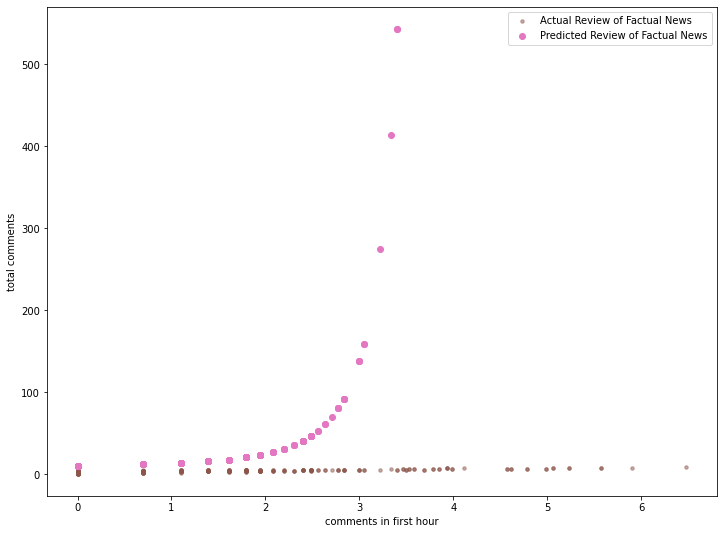

In [234]:
indep = 1 

# indep_dict = {
#     1: "avg cmt length",
#     2: "avg upvotes",
#     3: "num authors",
#     4: "comments in first hour",
# }
indep_dict = {
    1: "comments in first hour",
}

use_MCMC = True

if use_MCMC:
    eta_loc = eta_means
else:
    eta_loc = pyro.param('eta_loc').detach()

# eta_loc = torch.Tensor([[ 0.2019, -0.0130,  0.1875],
#                         [ 0.3866, -0.6894,  0.0956]]

phi = torch.matmul(eta_loc, t_data.T)

t = torch.Tensor(p_types).long()

indeps = torch.tensor(p_data)

coefs = torch.tensor(phi[:,t]) # (num_p_indeps,num_posts)

alpha = 1. / torch.exp(torch.mul(coefs, indeps.T).sum(dim=0))

y_pred = np.power(2., 1. / np.array(alpha)).reshape((-1,1))



print(y_pred_svi.shape)
print(y.shape)



# y_pred_mcmc = float(phi_means[0])
# y_pred_mcmc += float(phi_means[1]) * p_data[:,indep]


plt.figure(figsize=(12,9))

types = np.unique(p_types)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_choices = np.random.choice(colors, size=len(types), replace=False)

for i, t in enumerate(types):
    if t == 2:
        y_pred_t = y_pred[p_types == t]
        y_t = 1 * y[p_types == t]
        x_t = p_data[p_types == t,indep]

        type_label = labels[int(t)]

        color = color_choices[i]
        plt.scatter(np.log(x_t), np.log(y_t), alpha=0.5, s=12, c=color, label=f"Actual {type_label}")
        plt.scatter(np.log(x_t), np.log(y_pred_t), c="tab:pink", label=f"Predicted {type_label}")
    
# plt.plot(np.array(p_data[:,indep]), np.array(y_pred_mcmc), c='tab:green', label=f'MCMC: {phi_means[0]}, {phi_means[1]}') # MCMC
plt.xlabel(indep_dict[indep])
plt.ylabel('total comments')
plt.legend()
plt.ylim(0,10)
plt.show()

In [180]:
p_data[:,indep].shape

(21830,)

Interpretation:

- For posts with no comments in the first hour, we expect 7.23 comments in total
- For every comment in the first hour, we expect an additional 6.43 comments in total

----

/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/venv/lib/python3.8/site-packages/arviz/data/io_pyro.py:152: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


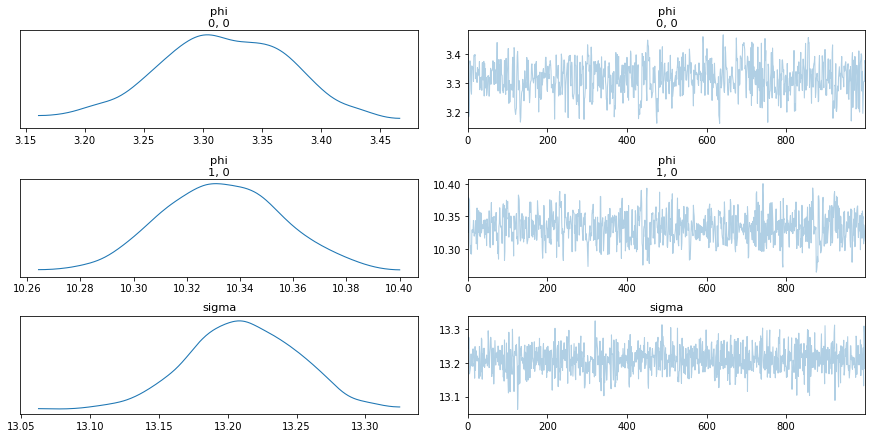

In [53]:
data = az.from_pyro(mcmc)
az.plot_trace(data, compact=False);

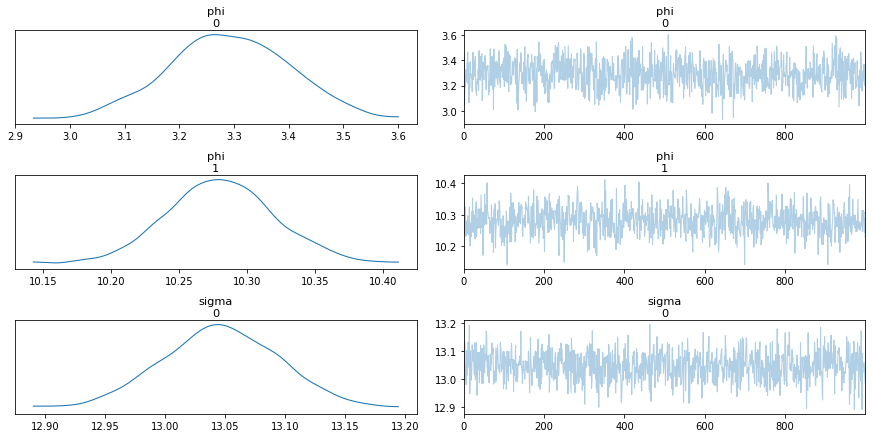

In [58]:
az_samples = az.convert_to_inference_data(svi_samples)
az.plot_trace(az_samples, compact=False);

# Why Pareto?
Our distribution of total comments follows a power law.

Text(0, 0.5, 'frequency')

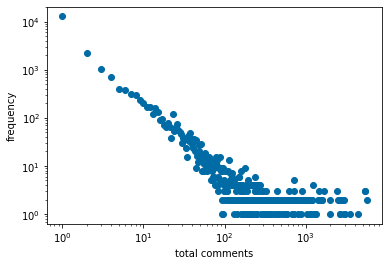

In [97]:
max_ct = np.max(y)
unique, counts = np.unique(y, return_counts=True)
plt.scatter(unique, counts)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("total comments")
plt.ylabel("frequency")
plt.show()

Fake news: expect relatively flatter (more with lots, fewer with few!)

Reviews: expect steeper (fewer comments very common)

Note that our first hour comments are also distributed similarly.

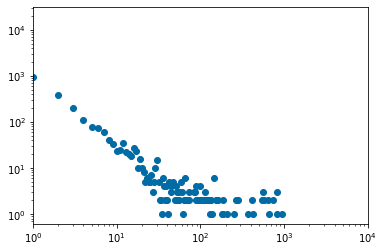

In [95]:
max_ct = np.max(p_data[:,1])
unique, counts = np.unique(p_data[:,1], return_counts=True)
plt.scatter(unique, counts)
plt.yscale("log")
plt.xscale("log")
plt.xlim(1, 10000)
plt.xlabel("first hour comments")
plt.ylabel("frequency")
plt.show()

In [93]:
p_data[:,1].shape

(21830,)